<a href="https://www.kaggle.com/code/yoanndev90/open-insect-id-notebook?scriptVersionId=293792191" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Cette ligne est destinée à convertir un notebook importé en script Python, car l'import de scripts Python n'est pas directement possible via Kaggle.

```sh
!jupyter nbconvert --to python /kaggle/input/utility-scripts-80b72cee7e/__notebook__.ipynb --output-dir=/kaggle/working --output=utils
```

In [ ]:
!jupyter nbconvert --to python /kaggle/input/utility-scripts-80b72cee7e/__notebook__.ipynb --output-dir=/kaggle/working --output=utils

In [2]:
import os
import json
import glob
import re
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from collections import Counter, defaultdict
import ijson
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

In [3]:
import sys
sys.path.append('/kaggle/working')
from utils import *

imported_funcs = [name for name in dir() if not name.startswith('_') and callable(globals()[name])]
print("Fonctions importées :", imported_funcs)

Fonctions importées : ['Counter', 'DataLoader', 'Dataset', 'Path', 'ThreadPoolExecutor', 'as_completed', 'build_hierarchy_labels', 'build_taxa_maps', 'defaultdict', 'exit', 'get_ipython', 'parse_taxonomy', 'parse_taxonomy_folders', 'quit', 'save_hierarchy_map', 'scan_corrupted_images', 'tree', 'verify_image_validity']


In [4]:
from utils import parse_taxonomy, verify_image_validity

example = "train/train/00980_Animalia_Arthropoda_Insecta_Lepidoptera_Erebidae_Arctia_virginalis/464f3a34-4c04-4eb3-afa2-6cb7444c3fa3.jpg"
taxonomy = parse_taxonomy(example)
print("Résultat:", taxonomy)
validity = verify_image_validity(example)
print("Image valide" if validity else "Image invalide")

Résultat: {'ordre': 'Lepidoptera', 'famille': 'Erebidae', 'genre': 'Arctia', 'espece': 'virginalis'}
Image valide


In [6]:
from utils import tree

# total = tree(''/kaggle/input/inaturalist-insects/'', 2)                   # Très long temps d'attente (30min-1h)
total = tree('/kaggle/input/inaturalist-insects/val-json/', 2)
print(f"\nNombre total de fichiers : {total}")


Nombre total de fichiers : 1


In [8]:
import ijson

def load_annotated_images(json_path):
    """Charge lat/lon par file_name depuis train_mini_json ou train_json."""
    annotated = {}
    with open(json_path, 'rb') as f:
        parser = ijson.items(f, 'images.item')
        for img in parser:
            filename = img.get('file_name', '')
            lat = float(img.get('latitude')) if img.get('latitude') is not None else 0.0
            lon = float(img.get('longitude')) if img.get('longitude') is not None else 0.0
            annotated[filename] = (lat, lon)
    return annotated

In [9]:
from collections import Counter

def compute_stats(full_taxa_map, full_geo_db, species_encountered):
    """Calcule toutes stats."""
    ordre_count = Counter()
    famille_count = Counter()
    genre_count = Counter()
    espece_count = Counter()
    
    for taxon_key, hier in full_taxa_map.items():
        ordre_count[hier['ordre']] += 1
        famille_count[hier['famille']] += 1
        genre_count[hier['genre']] += 1
        espece_count[hier['espece']] += 1
    
    homonyms_count = len([s for s in species_encountered if len(species_encountered[s]) > 1])
    homonyms_dirs = sum(len(species_encountered[s]) for s in species_encountered if len(species_encountered[s]) > 1)
    
    taxon_geo_counts = {str(k): len(v) for k, v in full_geo_db.items()}
    geo_taxa = len(full_geo_db)
    total_taxa = len(full_taxa_map)
    multi_geo = sum(1 for c in taxon_geo_counts.values() if c > 1)
    
    return {
        'total_dirs': len(species_encountered),
        'unique_taxa': total_taxa,
        'geo_coverage': geo_taxa / total_taxa if total_taxa else 0,
        'homonyms': {'names': homonyms_count, 'dirs': homonyms_dirs},
        'hierarchy': {
            'ordres': len(ordre_count), 'familles': len(famille_count), 'genres': len(genre_count)
        },
        'taxon_geo_counts': taxon_geo_counts
    }, ordre_count, famille_count, genre_count

In [12]:
from utils import parse_taxonomy_folders, build_taxa_maps

annotated_images = load_annotated_images('/kaggle/input/inaturalist-insects/train_mini-json/train_mini.json')
species_encountered, unparsed_dirs = parse_taxonomy_folders('/kaggle/input/inaturalist-insects/train_mini/train_mini/')
full_taxa_map, full_geo_db = build_taxa_maps(species_encountered, annotated_images, '/kaggle/input/inaturalist-insects/train_mini/train_mini/')
stats, ordre_count, famille_count, genre_count = compute_stats(full_taxa_map, full_geo_db, species_encountered)

print(f"✅ {stats['unique_taxa']} taxons (sur {stats['total_dirs']} dossiers)")
print(f"Homonymes: {stats['homonyms']['names']} noms => {stats['homonyms']['dirs']} dossiers")
print(f"Hiérarchie: {stats['hierarchy']['ordres']} ordres, {stats['hierarchy']['familles']} familles, {stats['hierarchy']['genres']} genres")
print(f"Géo: {len(full_geo_db)}/{len(full_taxa_map)} ({stats['geo_coverage']*100:.1f}%)")
print(f"Non parsés: {len(unparsed_dirs)}")


save_hierarchy_map(full_taxa_map, full_geo_db, stats, 'hierarchy_map.json')

✅ 2526 taxons (sur 2252 dossiers)
Homonymes: 185 noms => 459 dossiers
Hiérarchie: 17 ordres, 190 familles, 1472 genres
Géo: 2526/2526 (100.0%)
Non parsés: 0
💾 Sauvegardé: 2526 taxons dans hierarchy_map.json


In [13]:
from utils import build_hierarchy_labels

data_dir = '/kaggle/input/inaturalist-insects/'
hierarchy_map_file = '/kaggle/working/hierarchy_map.json'
final_hierarchy = build_hierarchy_labels(data_dir, hierarchy_map_file)

print("\nExemples:")
for idx in range(5):
    labels = final_hierarchy.get(idx)
    print(f"Class {idx}: {labels}") # [ordre_id, famille_id, genre_id, espece_id]

Classes: 2526 (scan /kaggle/input/inaturalist-insects/train_mini/train_mini)
Hiérarchie: 17 ordres, 190 fam., 1472 genres
✅ 2526/2526 mappées
💾 hierarchy_labels.json prêt pour training

Exemples:
Class 0: [0, 21, 124, 0]
Class 1: [0, 21, 1048, 1]
Class 2: [0, 21, 1219, 2]
Class 3: [0, 23, 185, 3]
Class 4: [0, 23, 1090, 4]


In [14]:
class RobustImageFolder(Dataset):
    """ImageFolder skip corrompus."""
    def __init__(self, root, transform=None, corrupt_files=None):
        self.root = root
        self.transform = transform
        self.corrupt_files = set(corrupt_files or [])
        
        self.classes, self.class_to_idx = self.find_classes(self.root)
        self.samples = self.make_dataset(self.root, self.class_to_idx)
        
        self.valid_indices = []
        for i, (path, _) in enumerate(self.samples):
            if os.path.relpath(path, self.root) not in self.corrupt_files:
                self.valid_indices.append(i)
    
    def find_classes(self, directory):
        """Trouve classes (dossiers)."""
        classes = [d.name for d in os.scandir(directory) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    
    def make_dataset(self, directory, class_to_idx):
        """Construit samples comme ImageFolder."""
        samples = []
        for target_class in sorted(self.class_to_idx.keys()):
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(directory, target_class)
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, class_index)
                    samples.append(item)
        return samples
    
    def __getitem__(self, index):
        path, target = self.samples[self.valid_indices[index]]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, target
    
    def __len__(self):
        return len(self.valid_indices)

In [15]:
from utils import scan_corrupted_images

corrupted_train, train_log = scan_corrupted_images('/kaggle/input/inaturalist-insects/train_mini/train_mini', max_workers=4)
corrupted_val, val_log = scan_corrupted_images('/kaggle/input/inaturalist-insects/val/val', max_workers=4)

with open(train_log) as f:
    print("\nCORROMPUS TRAIN:\n", f.read()[:500] + "..." if os.path.getsize(train_log) > 500 else f.read())

Scan 126300 JPG dans /kaggle/input/inaturalist-insects/train_mini/train_mini
❌ 01493_Animalia_Arthropoda_Insecta_Lepidoptera_Lyca: OSError: image file is truncated (115 bytes not processed)
❌ 01493_Animalia_Arthropoda_Insecta_Lepidoptera_Lyca: UnidentifiedImageError: cannot identify image file '/kaggle/input/inatural
❌ 01493_Animalia_Arthropoda_Insecta_Lepidoptera_Lyca: UnidentifiedImageError: cannot identify image file '/kaggle/input/inatural
❌ 01493_Animalia_Arthropoda_Insecta_Lepidoptera_Lyca: OSError: image file is truncated (43 bytes not processed)
❌ 01493_Animalia_Arthropoda_Insecta_Lepidoptera_Lyca: OSError: image file is truncated (124 bytes not processed)
❌ 00620_Animalia_Arthropoda_Insecta_Hemiptera_Pentat: UnidentifiedImageError: cannot identify image file '/kaggle/input/inatural
❌ 00620_Animalia_Arthropoda_Insecta_Hemiptera_Pentat: OSError: image file is truncated (62 bytes not processed)
❌ 00620_Animalia_Arthropoda_Insecta_Hemiptera_Pentat: OSError: image file is truncated

In [16]:
corrupt_train = []
with open('/kaggle/working/corrupted_train_mini.txt') as f:
    for line in f:
        if line.strip() and not line.startswith('#'):
            corrupt_train.append(line.strip())

corrupt_val = []
with open('/kaggle/working/corrupted_val.txt') as f:
    for line in f:
        if line.strip() and not line.startswith('#'):
            corrupt_val.append(line.strip())

In [18]:
class HierarchicalInsectDataset(Dataset):
    def __init__(self, root_dir, hierarchy_map, transform=None, corrupt_files=None):
        self.root_dir = root_dir
        self.hierarchy_map = hierarchy_map
        self.transform = transform
        
        self.inner_dataset = datasets.ImageFolder(root_dir)
        
        self.valid_indices = []
        for i in range(len(self.inner_dataset)):
            class_idx = self.inner_dataset.targets[i]
            if class_idx in self.hierarchy_map:
                # Skip si basename dans corrupt_files
                path = self.inner_dataset.samples[i][0]
                if os.path.basename(path) not in (corrupt_files or []):
                    self.valid_indices.append(i)
        
        print(f"Dataset {root_dir}: {len(self.inner_dataset)} → {len(self.valid_indices)} valides")
    
    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        img, class_idx = self.inner_dataset[real_idx]
        
        # Labels hiérarchiques [ordre_id, famille_id, genre_id, espece_id]
        hier_labels = torch.tensor(self.hierarchy_map[class_idx])
        
        if self.transform:
            img = self.transform(img)
        
        return img, hier_labels
    
    def __len__(self):
        return len(self.valid_indices)

In [19]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch

train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = HierarchicalInsectDataset(
    '/kaggle/input/inaturalist-insects/train_mini/train_mini', 
    final_hierarchy, 
    transform=train_transforms,
    corrupt_files=[os.path.basename(p) for p in corrupt_train]
)

val_dataset = HierarchicalInsectDataset(
    '/kaggle/input/inaturalist-insects/val/val', 
    final_hierarchy, 
    transform=val_transforms,
    corrupt_files=[os.path.basename(p) for p in corrupt_val]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Datasets hiérarchiques:")
print(f"  Train: {len(train_dataset)} images, 2526 classes")
print(f"  Val: {len(val_dataset)} images")
print(f"  Labels: ordre/famille/genre/espece [device={device}]")

img, labels = next(iter(train_loader))
print(f"Batch shape: {img.shape}, labels shape: {labels.shape}")  # [32,3,224,224], [32,4]

Dataset /kaggle/input/inaturalist-insects/train_mini/train_mini: 126300 → 126245 valides
Dataset /kaggle/input/inaturalist-insects/val/val: 25260 → 25260 valides
✅ Datasets hiérarchiques:
  Train: 126245 images, 2526 classes
  Val: 25260 images
  Labels: ordre/famille/genre/espece [device=cuda]
Batch shape: torch.Size([32, 3, 224, 224]), labels shape: torch.Size([32, 4])


In [26]:
class HierarchicalMobileNetV3(nn.Module):
    """MobileNetV3 avec outputs séparés par niveau."""
    def __init__(self, num_ordre=17, num_famille=190, num_genre=1472, num_espece=2526):
        super().__init__()
        backbone = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
        self.features = backbone.features
        self.avgpool = backbone.avgpool
        
        self.fc_shared = nn.Sequential(
            nn.Linear(960, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3)
        )
        
        # Heads indépendants (FIX: pas cumulatif)
        self.head_ordre = nn.Linear(512, num_ordre)
        self.head_famille = nn.Linear(512, num_famille)
        self.head_genre = nn.Linear(512, num_genre)
        self.head_espece = nn.Linear(512, num_espece)
    
    def forward(self, x, return_probs=False):
        x = self.features(x)
        x = self.avgpool(x)
        feats = torch.flatten(x, 1)
        shared = self.fc_shared(feats)
        
        ordre = self.head_ordre(shared)
        famille = self.head_famille(shared)
        genre = self.head_genre(shared)
        espece = self.head_espece(shared)
        
        if return_probs:
            return (F.softmax(ordre, dim=1), F.softmax(famille, dim=1), 
                   F.softmax(genre, dim=1), F.softmax(espece, dim=1))
        
        max_classes = 2526
        preds = torch.zeros(x.size(0), 4, max_classes, device=x.device)
        preds[:, 0, :ordre.size(1)] = ordre
        preds[:, 1, :famille.size(1)] = famille
        preds[:, 2, :genre.size(1)] = genre
        preds[:, 3, :espece.size(1)] = espece
        
        return preds  # [B,4,2526]

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import json

with open('hierarchy_labels.json') as f:
    stats = json.load(f)['stats']
    
num_ordre = stats['ordres']      # 17
num_famille = stats['familles']  # 190
num_genre = stats['genres']     # 1472
num_espece = stats['total_classes']  # 2526

model = HierarchicalMobileNetV3(num_ordre, num_famille, num_genre, num_espece).to(device)

print(f"Model: {sum(p.numel() for p in model.parameters()):,} params")
print(f"✅ GPU: {next(model.parameters()).device}")

model.eval()
with torch.no_grad():
    batch_img, batch_labels = next(iter(train_loader))
    preds = model(batch_img.to(device))  # [32,4,2526]
    loss = criterion(preds, batch_labels.to(device))
    print(f"✅ Test OK: preds={preds.shape}, loss={loss.item():.3f}")

Model: 5,622,173 params
✅ GPU: cuda:0
✅ Test OK: preds=torch.Size([32, 4, 2526]), loss=7.144


In [28]:
class HierarchicalLoss(nn.Module):
    def __init__(self, num_classes_per_level):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.weights = torch.tensor([1.0, 2.0, 5.0, 10.0])
        self.num_classes = num_classes_per_level  # [17,190,1472,2526]
    
    def forward(self, preds, targets):
        loss = 0
        for i in range(4):
            mask = torch.arange(self.num_classes[i], device=preds.device)
            lvl_pred = preds[:, i, mask]
            lvl_loss = self.ce(lvl_pred, targets[:, i])
            loss += self.weights[i] * lvl_loss
        return loss / self.weights.sum()

criterion = HierarchicalLoss([num_ordre, num_famille, num_genre, num_espece])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

Labels shape: torch.Size([32, 4]), dtype: torch.int64
Sample labels[0]: tensor([  0,  21, 124,   0], device='cuda:0')
preds shape: torch.Size([32, 4, 2526])
🚀 Début entraînement hiérarchique


Epoch  0: 100%|██████████| 3946/3946 [14:41<00:00,  4.48it/s, loss=4.2752]


Epoch  0: Train=4.2871 | Val=3.3380
  Accs - Ordre:0.8377 | Fam:0.5916 | Genre:0.3169 | Esp:0.2941


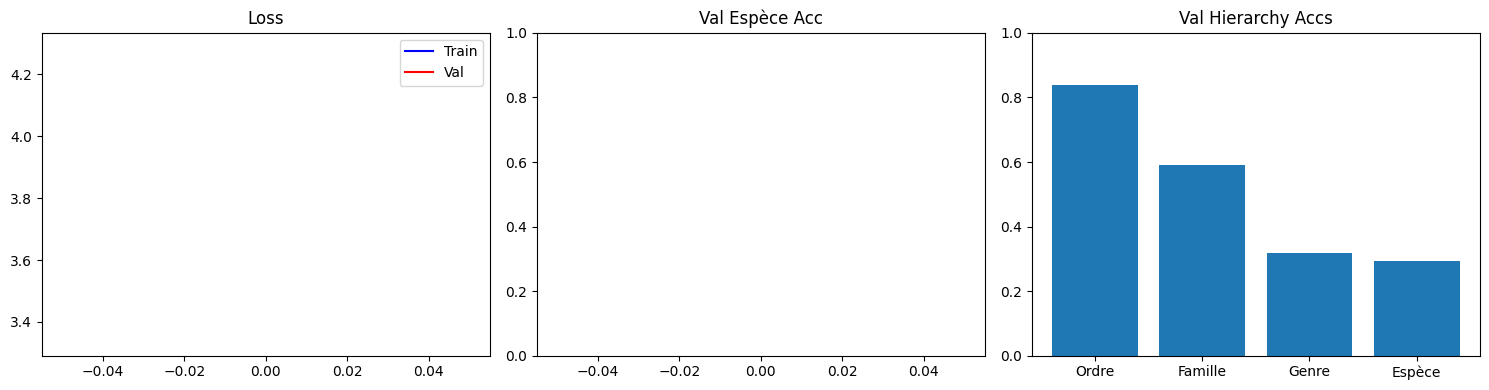

🔥 BEST: Esp.Acc=0.2941


Epoch  1: 100%|██████████| 3946/3946 [14:50<00:00,  4.43it/s, loss=3.9743]


Epoch  1: Train=3.3498 | Val=2.6429
  Accs - Ordre:0.8574 | Fam:0.6368 | Genre:0.4253 | Esp:0.4026


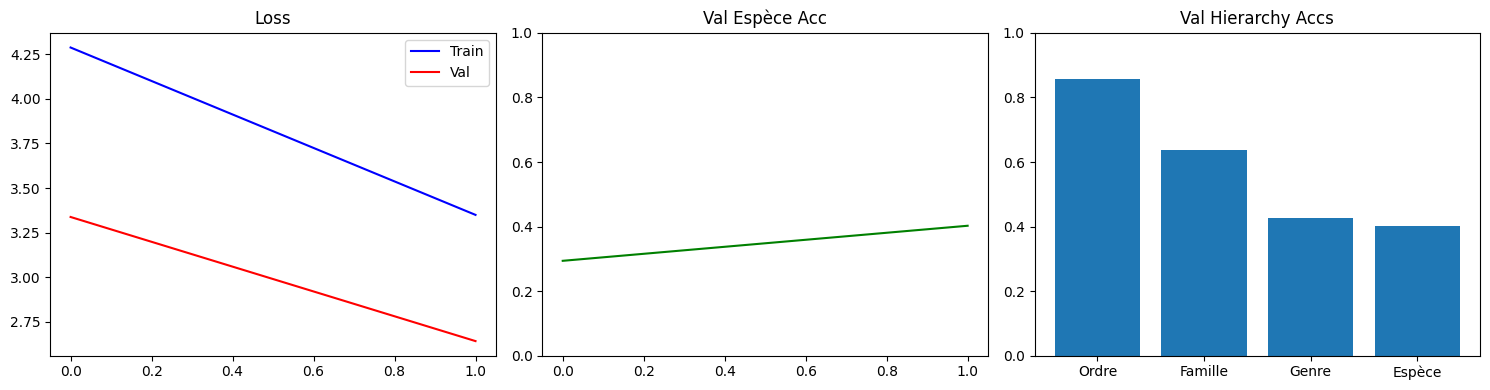

🔥 BEST: Esp.Acc=0.4026


Epoch  2: 100%|██████████| 3946/3946 [14:43<00:00,  4.47it/s, loss=4.2375]


Epoch  2: Train=2.7887 | Val=2.2174
  Accs - Ordre:0.8668 | Fam:0.6681 | Genre:0.5089 | Esp:0.4757


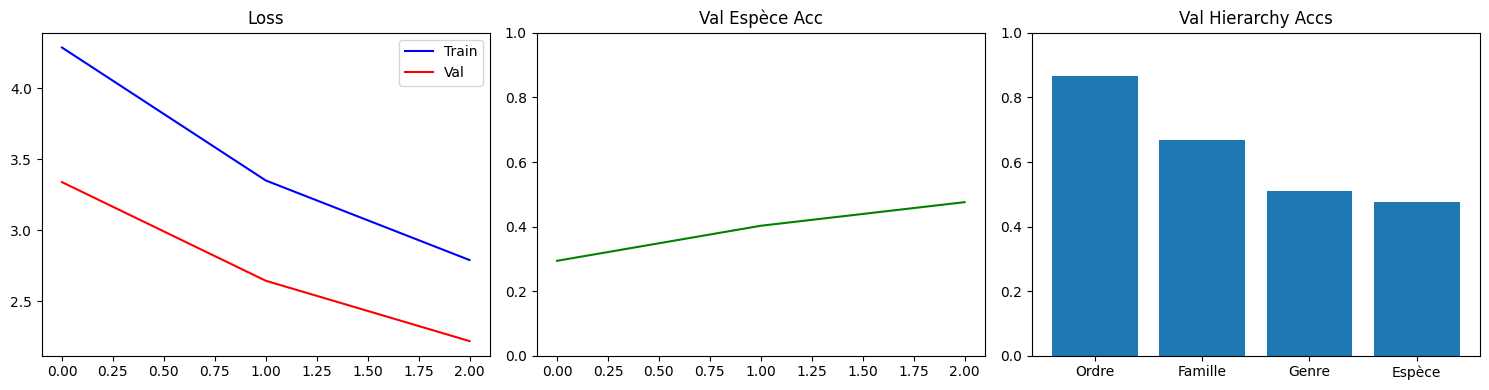

🔥 BEST: Esp.Acc=0.4757


Epoch  3: 100%|██████████| 3946/3946 [14:46<00:00,  4.45it/s, loss=3.5917]


Epoch  3: Train=2.4282 | Val=1.9575
  Accs - Ordre:0.8768 | Fam:0.6908 | Genre:0.5586 | Esp:0.5169


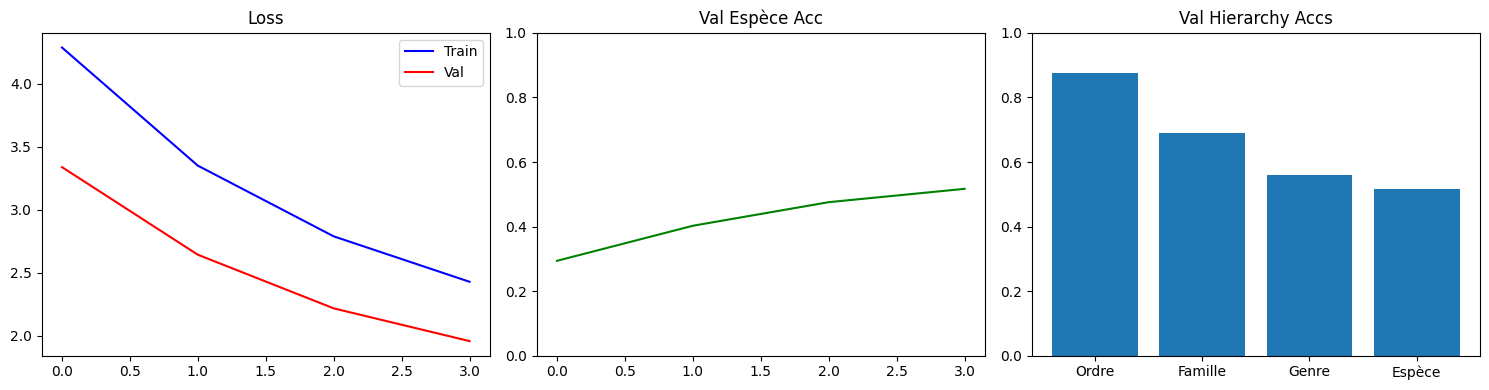

🔥 BEST: Esp.Acc=0.5169


Epoch  4: 100%|██████████| 3946/3946 [15:15<00:00,  4.31it/s, loss=2.0400]


Epoch  4: Train=2.1945 | Val=1.8358
  Accs - Ordre:0.8782 | Fam:0.7030 | Genre:0.5843 | Esp:0.5288


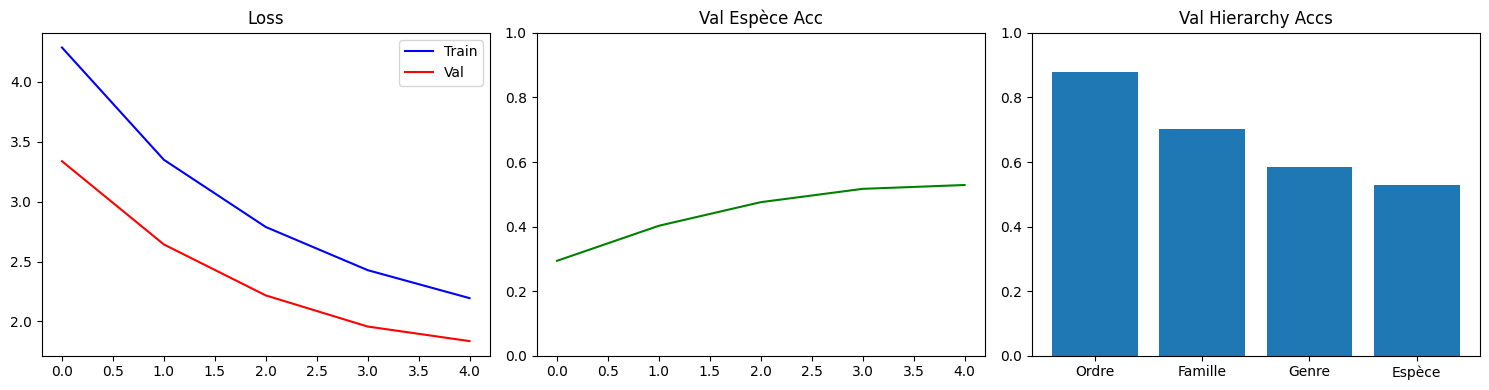

🔥 BEST: Esp.Acc=0.5288


Epoch  5: 100%|██████████| 3946/3946 [14:56<00:00,  4.40it/s, loss=2.1264]


Epoch  5: Train=2.0094 | Val=1.6913
  Accs - Ordre:0.8813 | Fam:0.7215 | Genre:0.6139 | Esp:0.5583


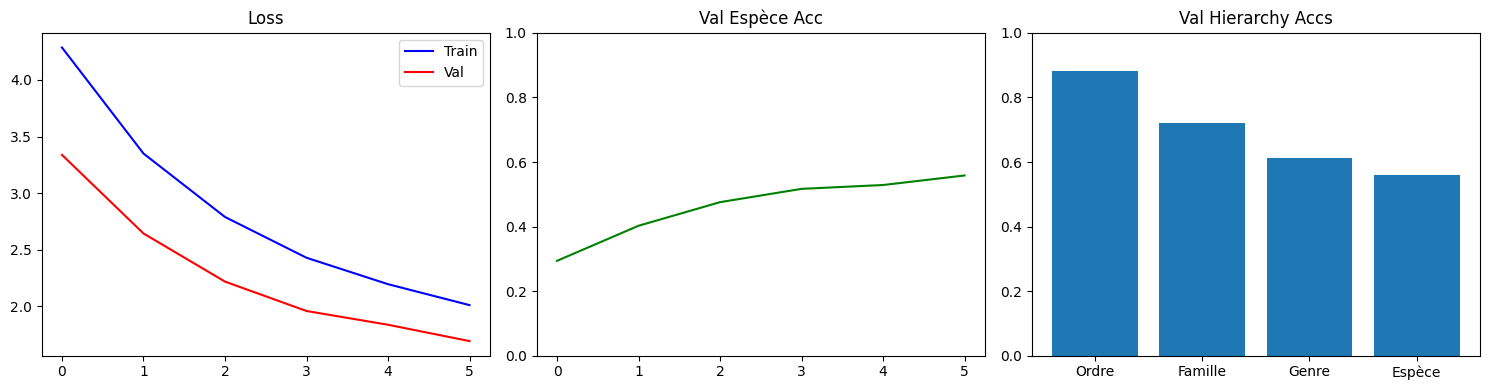

🔥 BEST: Esp.Acc=0.5583


Epoch  6: 100%|██████████| 3946/3946 [14:28<00:00,  4.55it/s, loss=3.1302]


Epoch  6: Train=1.8717 | Val=1.6075
  Accs - Ordre:0.8835 | Fam:0.7297 | Genre:0.6325 | Esp:0.5727


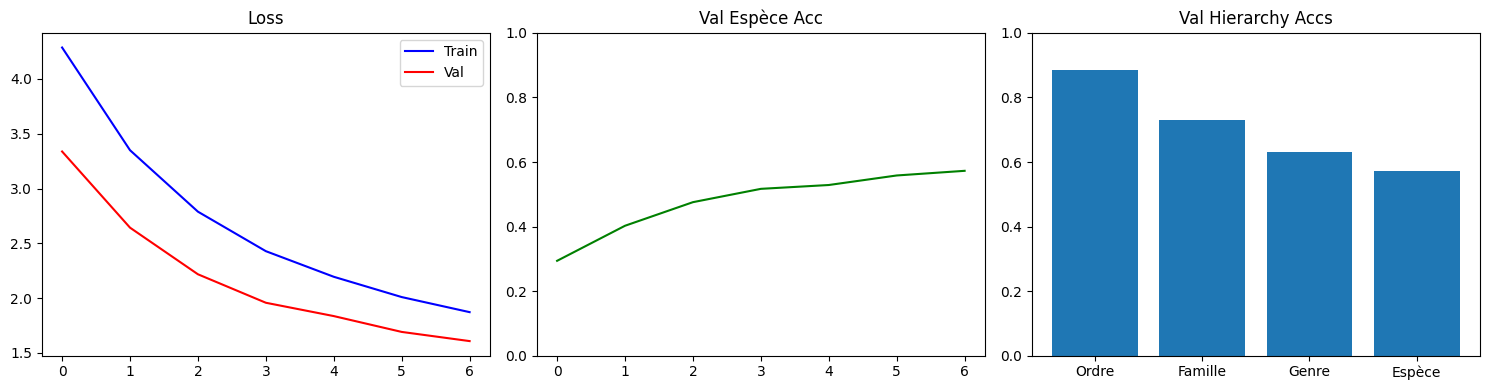

🔥 BEST: Esp.Acc=0.5727


Epoch  7: 100%|██████████| 3946/3946 [14:34<00:00,  4.51it/s, loss=1.6285]


Epoch  7: Train=1.7805 | Val=1.5330
  Accs - Ordre:0.8874 | Fam:0.7410 | Genre:0.6471 | Esp:0.5894


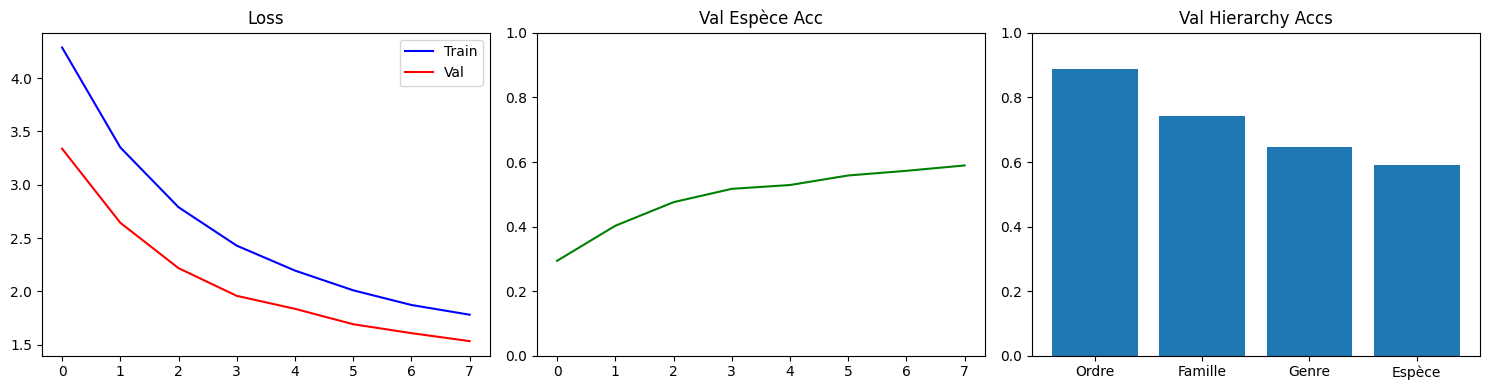

🔥 BEST: Esp.Acc=0.5894


Epoch  8: 100%|██████████| 3946/3946 [14:32<00:00,  4.52it/s, loss=1.6644]


Epoch  8: Train=1.6723 | Val=1.4660
  Accs - Ordre:0.8905 | Fam:0.7502 | Genre:0.6600 | Esp:0.6040


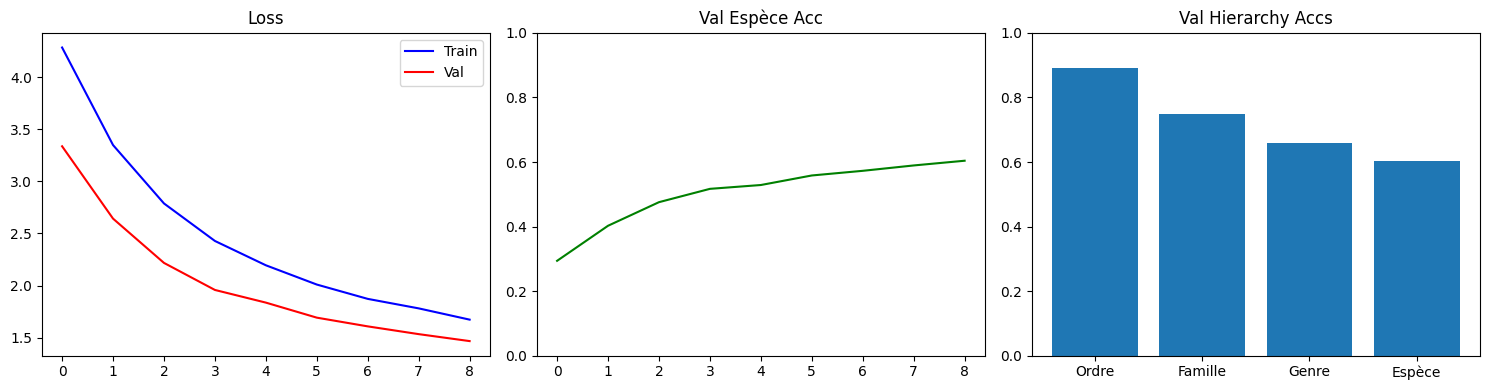

🔥 BEST: Esp.Acc=0.6040


Epoch  9: 100%|██████████| 3946/3946 [14:19<00:00,  4.59it/s, loss=1.9929]


Epoch  9: Train=1.5514 | Val=1.4210
  Accs - Ordre:0.8926 | Fam:0.7538 | Genre:0.6720 | Esp:0.6096


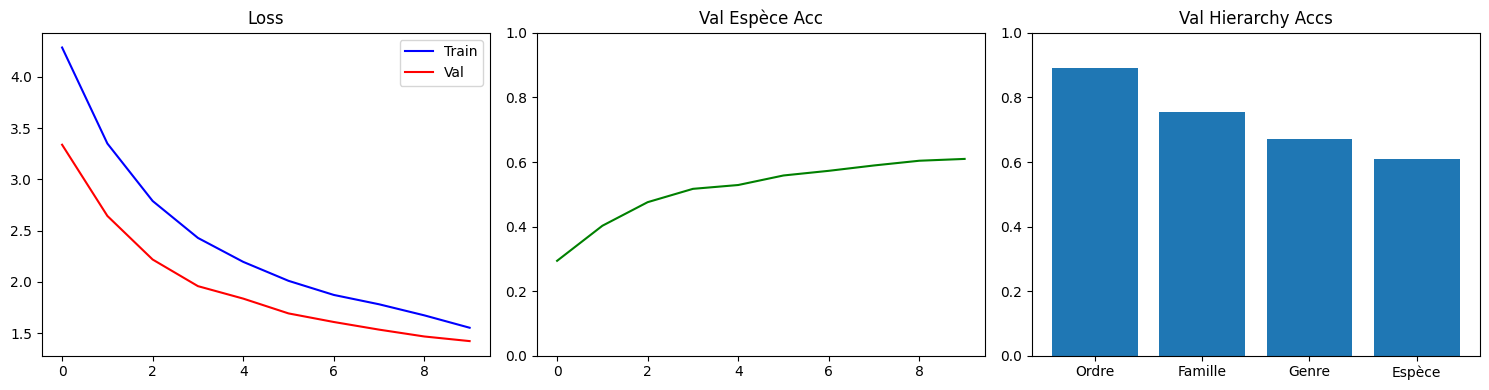

/tmp/ipykernel_55/1069506765.py:109: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
/tmp/ipykernel_55/312458342.py:33: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if return_probs:


RuntimeError: number of output names provided (8) exceeded number of outputs (1)

In [30]:
import torch
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.onnx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Labels shape: {labels.shape}, dtype: {labels.dtype}")
print(f"Sample labels[0]: {labels[0]}")
print(f"preds shape: {preds.shape}")

criterion = HierarchicalLoss([num_ordre, num_famille, num_genre, num_espece])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, min_lr=1e-6)
scaler = GradScaler('cuda')

best_val_acc = 0
patience_counter = 0
patience = 10

train_losses, val_losses, val_accs = [], [], []
hierarchy_accs = {'ordre': [], 'famille': [], 'genre': [], 'espece': []}  # Track real hierarchy accs

print("🚀 Début entraînement hiérarchique")

for epoch in range(50):
    # === TRAIN ===
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch:2d}')
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with autocast('cuda'):
            preds = model(images)  # [B,4,2526]
            loss = criterion(preds, labels)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_train_loss = train_loss / len(train_loader)
    
    # === VAL ===
    model.eval()
    val_loss_total = 0
    val_correct = [0,0,0,0]  # [ordre, famille, genre, espèce]
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            preds = model(images)
            loss = criterion(preds, labels)
            val_loss_total += loss.item()
        
            for lvl in range(4):
                logits = preds[:, lvl, :criterion.num_classes[lvl]]
                lvl_preds = logits.argmax(1)
                val_correct[lvl] += (lvl_preds == labels[:, lvl]).sum().item()
        
            val_total += labels.size(0)

    avg_val_loss = val_loss_total / len(val_loader)
    hierarchy_accs_current = {
        'ordre': val_correct[0]/val_total,
        'famille': val_correct[1]/val_total,
        'genre': val_correct[2]/val_total,
        'espece': val_correct[3]/val_total
    }
    val_acc = hierarchy_accs_current['espece']
    
    print(f"Epoch {epoch:2d}: Train={avg_train_loss:.4f} | Val={avg_val_loss:.4f}")
    print(f"  Accs - Ordre:{hierarchy_accs_current['ordre']:.4f} | Fam:{hierarchy_accs_current['famille']:.4f} | "
          f"Genre:{hierarchy_accs_current['genre']:.4f} | Esp:{val_acc:.4f}")
    
    # Update tracking lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    for k in hierarchy_accs:
        hierarchy_accs[k].append(hierarchy_accs_current[k])
    
    # PLOT avec vraies accuracies
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1); 
    plt.plot(train_losses, 'b-', label='Train'); plt.plot(val_losses, 'r-', label='Val'); plt.legend(); plt.title('Loss')
    plt.subplot(1,3,2); plt.plot(val_accs, 'g-'); plt.title('Val Espèce Acc'); plt.ylim(0,1)
    plt.subplot(1,3,3); 
    keys = ['Ordre','Famille','Genre','Espèce']
    accs = [hierarchy_accs_current['ordre'], hierarchy_accs_current['famille'], 
            hierarchy_accs_current['genre'], hierarchy_accs_current['espece']]
    plt.bar(keys, accs); plt.title('Val Hierarchy Accs'); plt.ylim(0,1)
    plt.tight_layout(); plt.show()
    
    # EXPORT ONNX toutes les 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        
        # Test forward pour voir les vraies outputs
        with torch.no_grad():
            test_output = model(dummy_input)
            print(f"Model outputs shape: {test_output.shape if isinstance(test_output, torch.Tensor) else [o.shape for o in test_output]}")
        
        # Export simple (1 input → 1 output principal)
        torch.onnx.export(
            model, 
            dummy_input, 
            f"insect_model_epoch_{epoch+1}.onnx",
            export_params=True, 
            opset_version=17,  # +récent = mieux support
            do_constant_folding=True,
            input_names=['image'],
            output_names=['logits'],  # 1 seul output
            dynamic_axes={
                'image': {0: 'batch_size'},
                'logits': {0: 'batch_size'}
            }
        )
        print(f"💾 ONNX exported: insect_model_epoch_{epoch+1}.onnx")

    
    # SAVE BEST
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'model': model.state_dict(),
            'optim': optimizer.state_dict(),
            'epoch': epoch,
            'val_acc': val_acc,
            'hierarchy_accs': hierarchy_accs_current,
            'stats': {'train_losses': train_losses.copy(), 'val_losses': val_losses.copy(), 
                     'val_accs': val_accs.copy(), 'hierarchy_accs': hierarchy_accs.copy()}
        }, 'best_hier_model.pth')
        print(f"🔥 BEST: Esp.Acc={val_acc:.4f}")
    else:
        patience_counter += 1
    
    scheduler.step(avg_val_loss)
    
    if patience_counter >= patience:
        print(f"🛑 Early Stop at epoch {epoch}")
        break

print(f"🏆 FINAL: Best Espèce Acc = {best_val_acc:.4f}")

✅ Repris epoch 9, Best Acc: 0.6040
📊 History: 9 epochs déjà faits
🚀 Début entraînement hiérarchique


Epoch  0: 100%|██████████| 3946/3946 [15:15<00:00,  4.31it/s, loss=3.3578]


Epoch  0: Train=1.5978 | Val=1.4366
  Accs - Ordre:0.8898 | Fam:0.7532 | Genre:0.6666 | Esp:0.6036


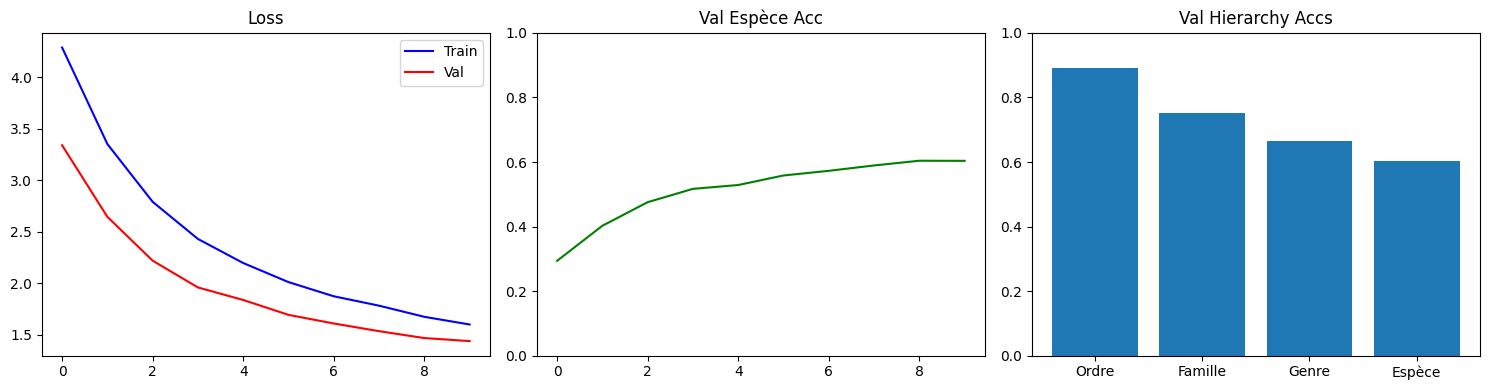

Epoch  1: 100%|██████████| 3946/3946 [14:35<00:00,  4.51it/s, loss=1.8464]


Epoch  1: Train=1.4536 | Val=1.3891
  Accs - Ordre:0.8923 | Fam:0.7609 | Genre:0.6802 | Esp:0.6162


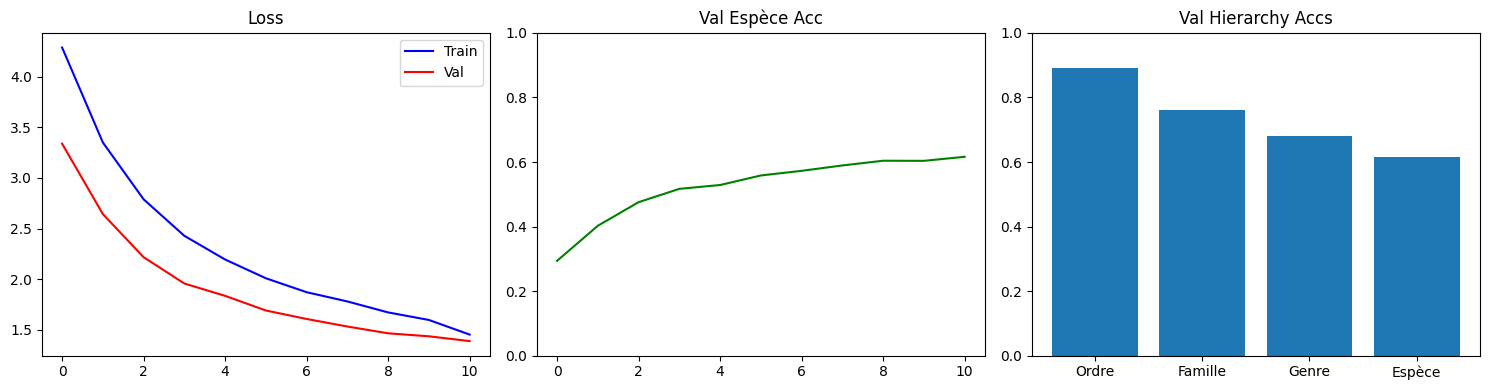

🔥 BEST: Esp.Acc=0.6162


Epoch  2: 100%|██████████| 3946/3946 [14:14<00:00,  4.62it/s, loss=3.3717]


Epoch  2: Train=1.4330 | Val=1.3837
  Accs - Ordre:0.8943 | Fam:0.7602 | Genre:0.6802 | Esp:0.6139


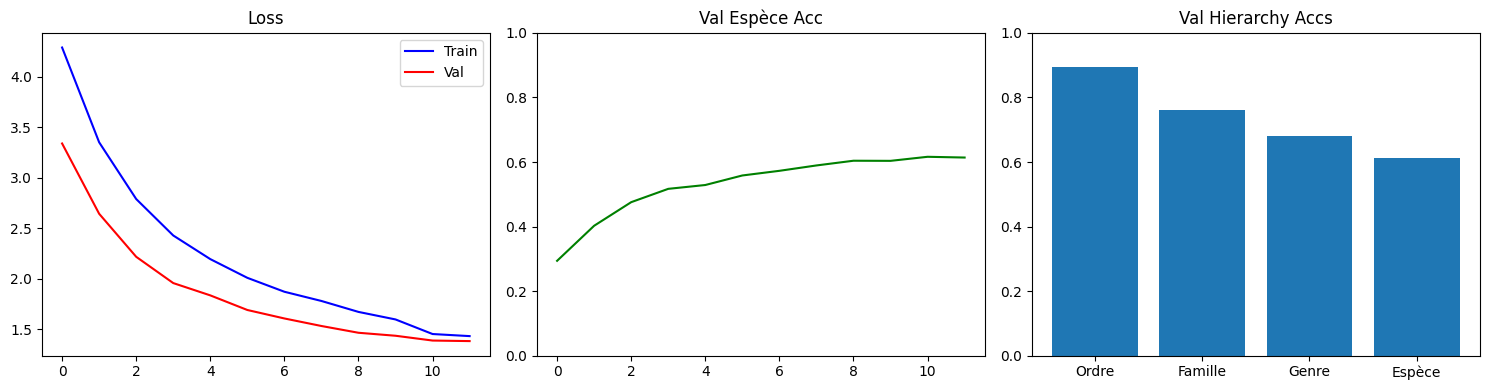

Epoch  3: 100%|██████████| 3946/3946 [13:56<00:00,  4.72it/s, loss=2.1589]


Epoch  3: Train=1.3600 | Val=1.3182
  Accs - Ordre:0.8966 | Fam:0.7702 | Genre:0.6949 | Esp:0.6293


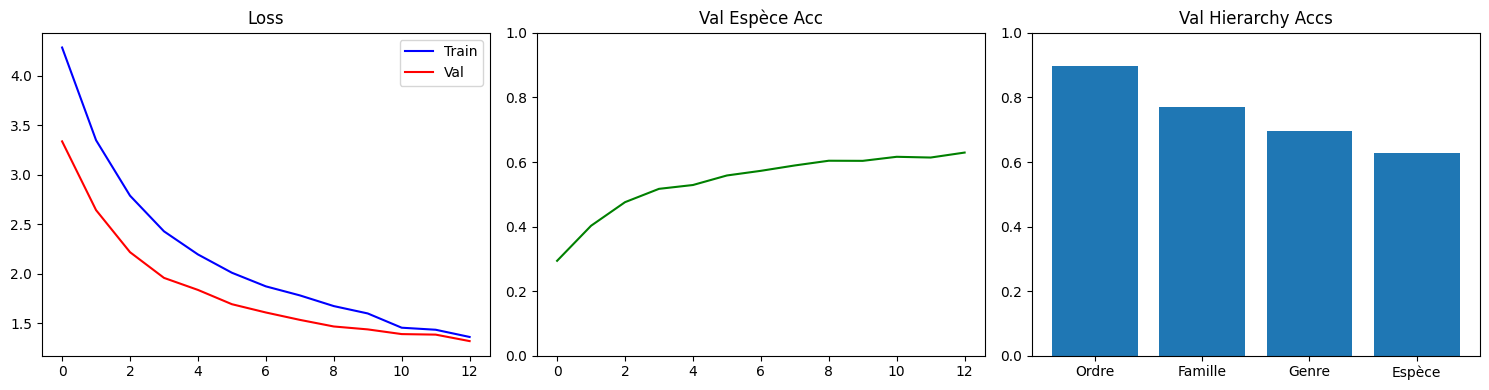

🔥 BEST: Esp.Acc=0.6293


Epoch  4: 100%|██████████| 3946/3946 [13:57<00:00,  4.71it/s, loss=2.4118]


Epoch  4: Train=1.2814 | Val=1.2933
  Accs - Ordre:0.8983 | Fam:0.7781 | Genre:0.7006 | Esp:0.6369


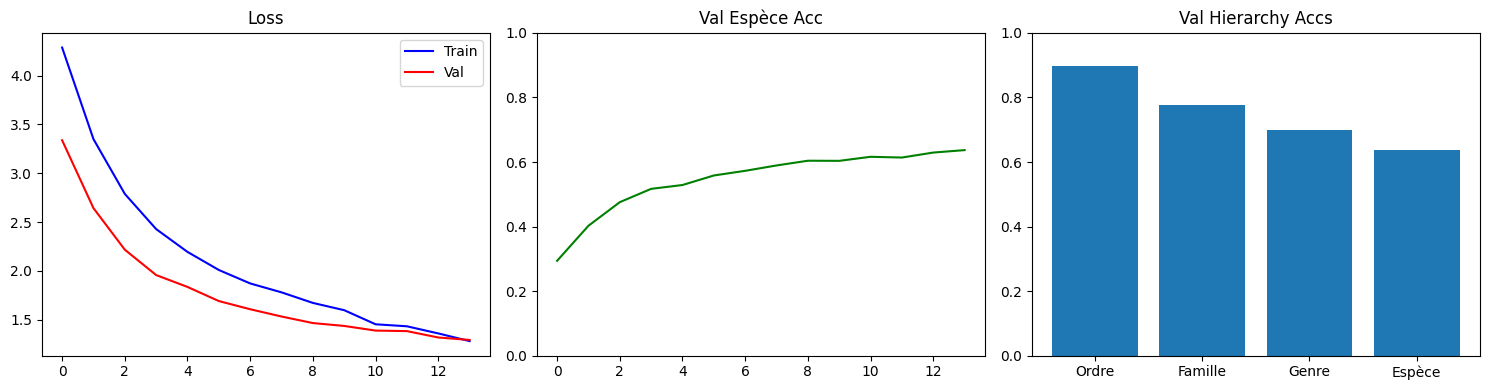

🔥 BEST: Esp.Acc=0.6369


Epoch  5: 100%|██████████| 3946/3946 [13:36<00:00,  4.83it/s, loss=0.8940]


Epoch  5: Train=1.2316 | Val=1.2666
  Accs - Ordre:0.8993 | Fam:0.7819 | Genre:0.7103 | Esp:0.6393


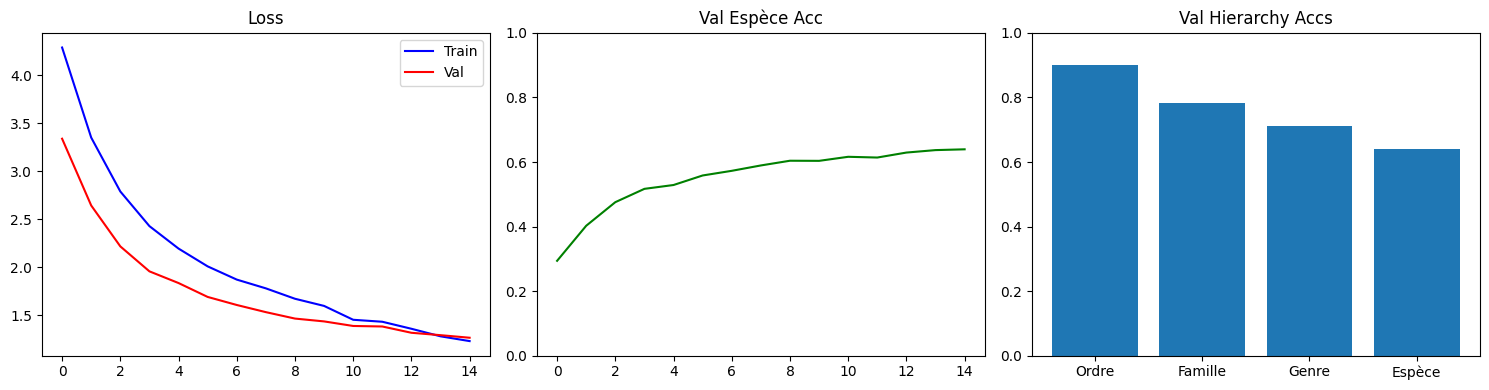

🔥 BEST: Esp.Acc=0.6393


Epoch  6: 100%|██████████| 3946/3946 [13:41<00:00,  4.80it/s, loss=0.5379]


Epoch  6: Train=1.1470 | Val=1.2659
  Accs - Ordre:0.8999 | Fam:0.7843 | Genre:0.7089 | Esp:0.6391


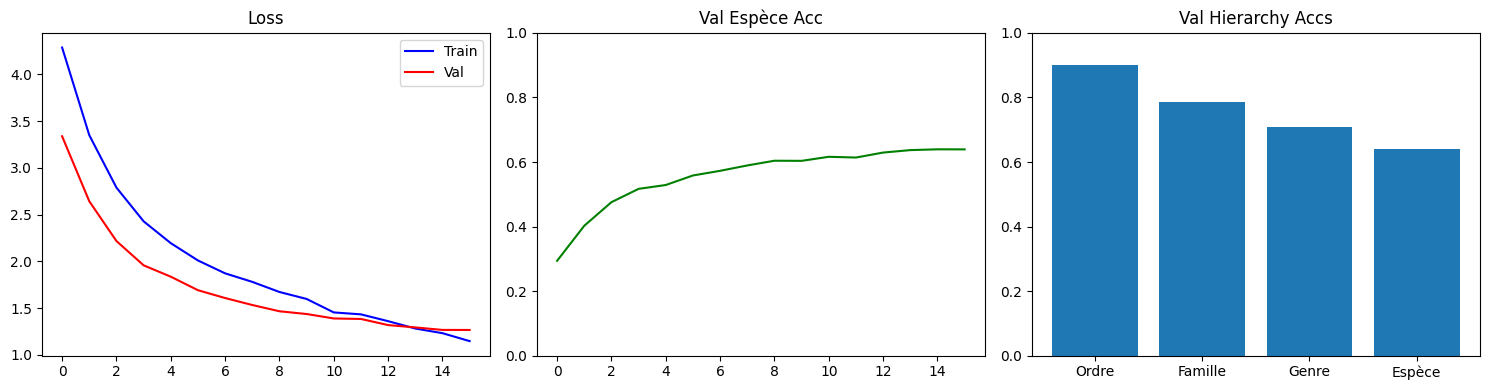

Epoch  7: 100%|██████████| 3946/3946 [13:40<00:00,  4.81it/s, loss=1.8996]


Epoch  7: Train=1.1224 | Val=1.2875
  Accs - Ordre:0.8986 | Fam:0.7786 | Genre:0.7040 | Esp:0.6349


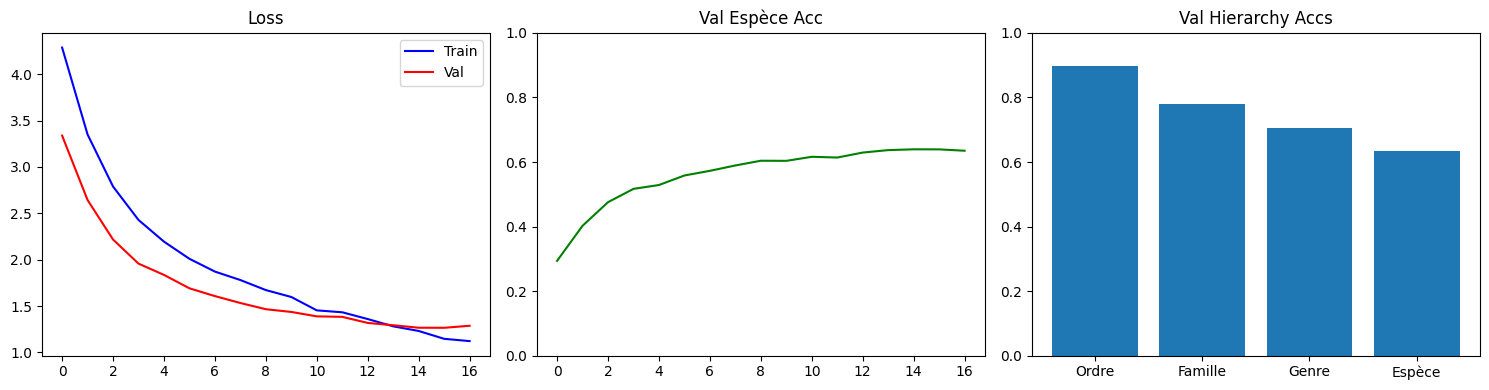

Epoch  8: 100%|██████████| 3946/3946 [13:46<00:00,  4.78it/s, loss=3.3622]


Epoch  8: Train=1.0871 | Val=1.2934
  Accs - Ordre:0.8981 | Fam:0.7782 | Genre:0.7063 | Esp:0.6367


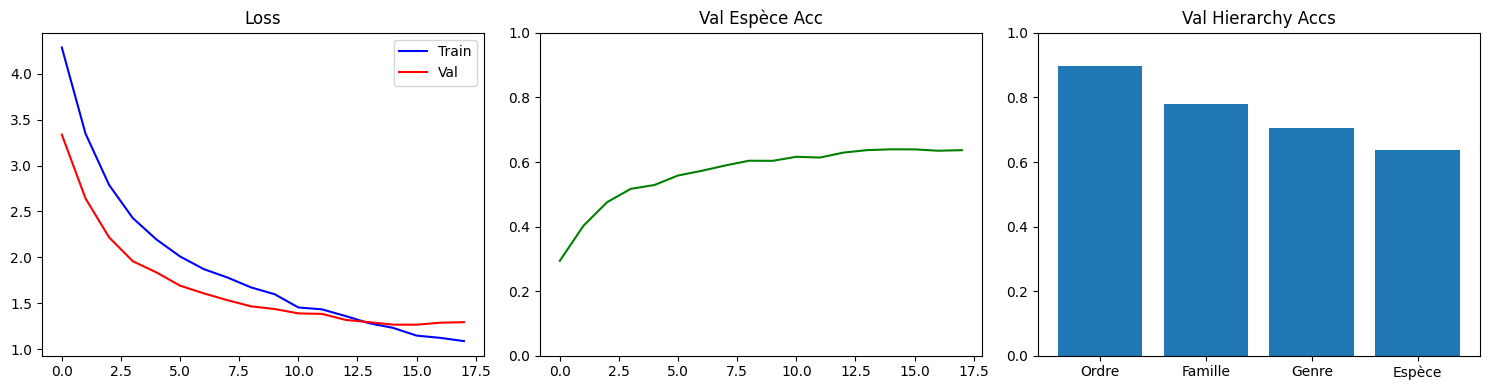

Epoch  9: 100%|██████████| 3946/3946 [13:52<00:00,  4.74it/s, loss=2.9882]


Epoch  9: Train=1.0662 | Val=1.2579
  Accs - Ordre:0.9007 | Fam:0.7867 | Genre:0.7124 | Esp:0.6426


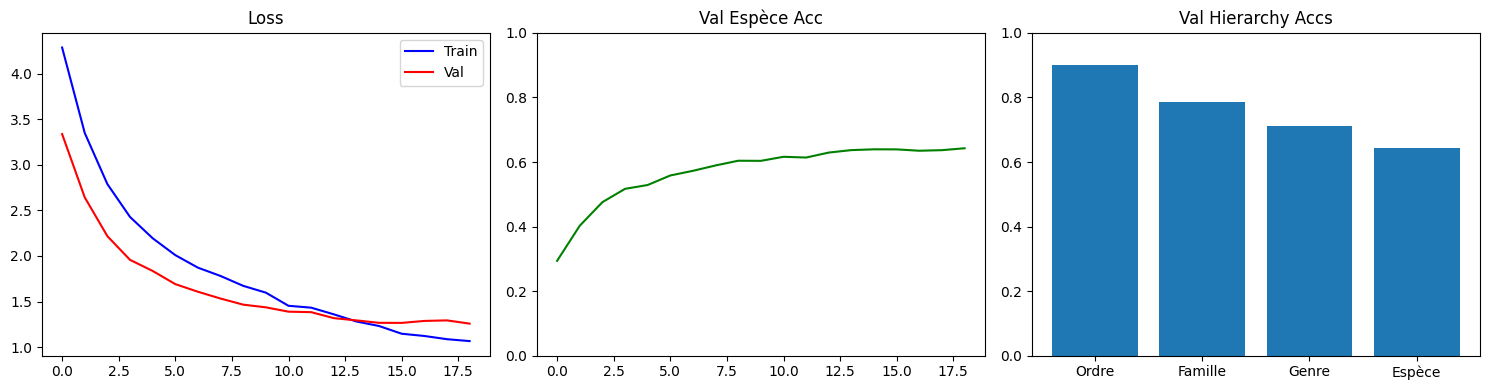

Model outputs shape: torch.Size([1, 4, 2526])


/tmp/ipykernel_55/3888533886.py:112: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
/tmp/ipykernel_55/312458342.py:33: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if return_probs:


💾 ONNX exported: insect_model_epoch_10.onnx
🔥 BEST: Esp.Acc=0.6426


Epoch 10: 100%|██████████| 3946/3946 [14:14<00:00,  4.62it/s, loss=2.3615]


Epoch 10: Train=1.0607 | Val=1.2432
  Accs - Ordre:0.9017 | Fam:0.7888 | Genre:0.7166 | Esp:0.6450


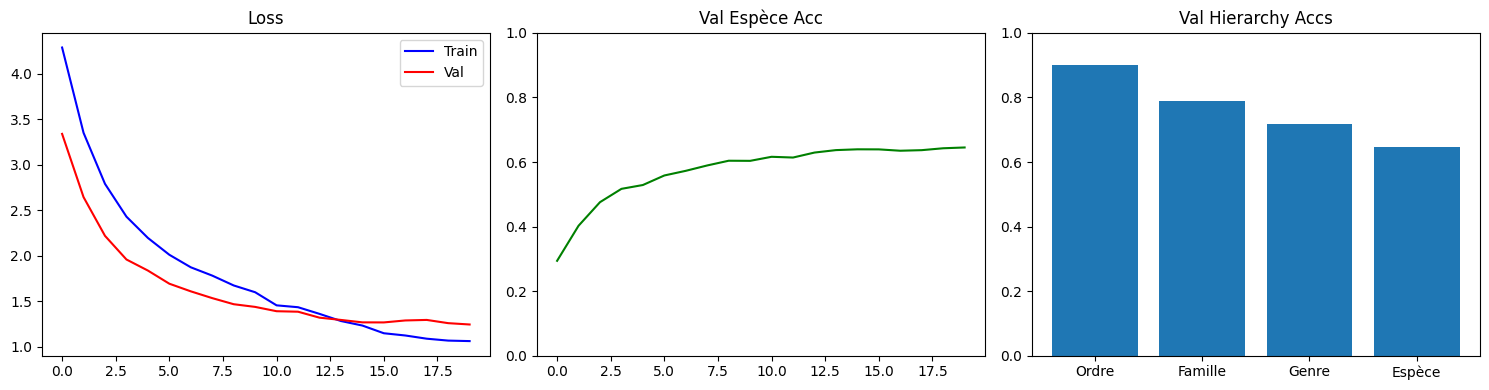

🔥 BEST: Esp.Acc=0.6450


Epoch 11: 100%|██████████| 3946/3946 [13:40<00:00,  4.81it/s, loss=3.8609]


Epoch 11: Train=0.9432 | Val=1.2487
  Accs - Ordre:0.9008 | Fam:0.7888 | Genre:0.7141 | Esp:0.6459


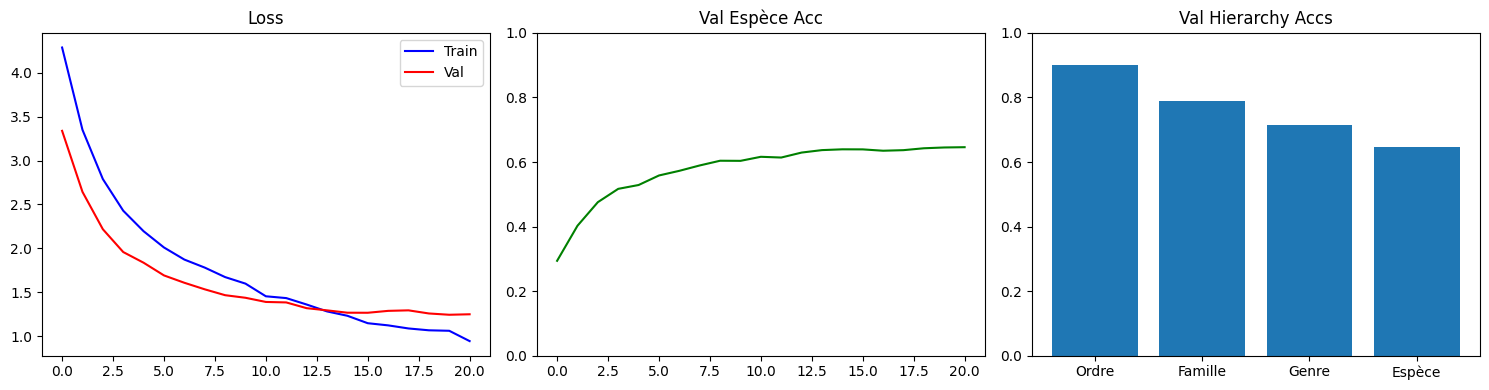

🔥 BEST: Esp.Acc=0.6459


Epoch 12: 100%|██████████| 3946/3946 [13:33<00:00,  4.85it/s, loss=2.7326]


Epoch 12: Train=0.9088 | Val=1.2152
  Accs - Ordre:0.9043 | Fam:0.7951 | Genre:0.7228 | Esp:0.6540


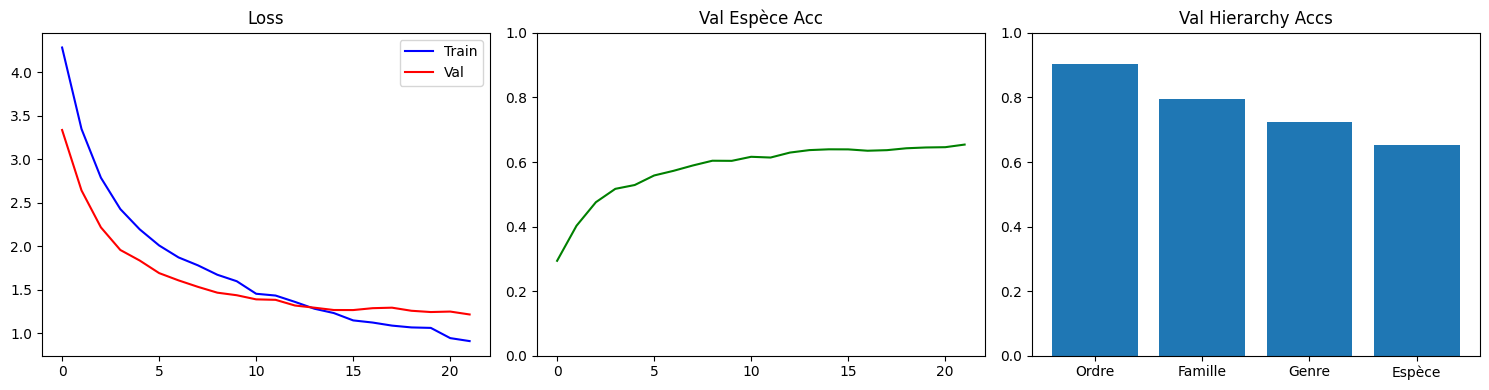

🔥 BEST: Esp.Acc=0.6540


Epoch 13: 100%|██████████| 3946/3946 [13:41<00:00,  4.80it/s, loss=1.4413]


Epoch 13: Train=0.9207 | Val=1.2330
  Accs - Ordre:0.9025 | Fam:0.7938 | Genre:0.7197 | Esp:0.6509


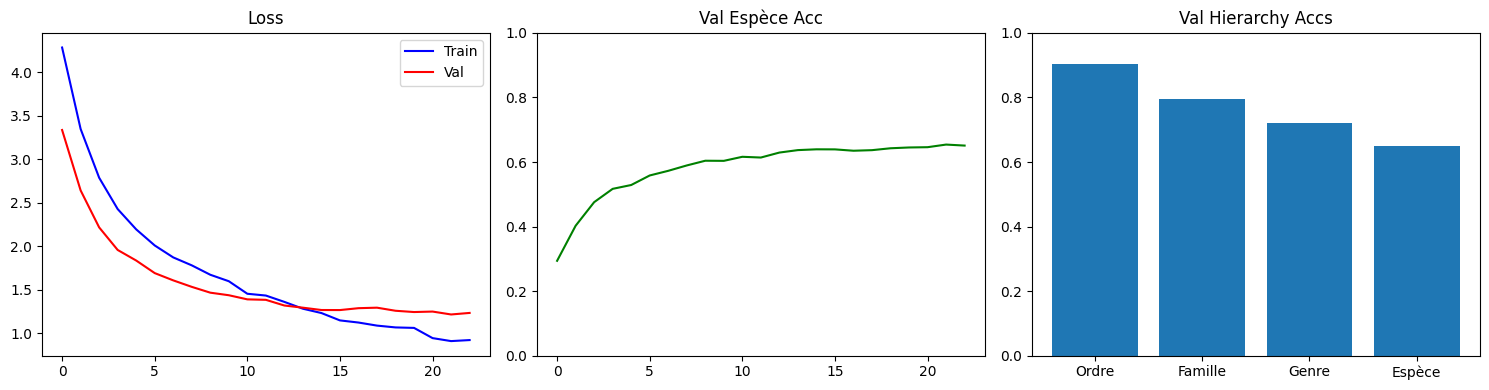

Epoch 14: 100%|██████████| 3946/3946 [13:47<00:00,  4.77it/s, loss=1.0587]


Epoch 14: Train=0.8658 | Val=1.2158
  Accs - Ordre:0.9035 | Fam:0.7958 | Genre:0.7255 | Esp:0.6545


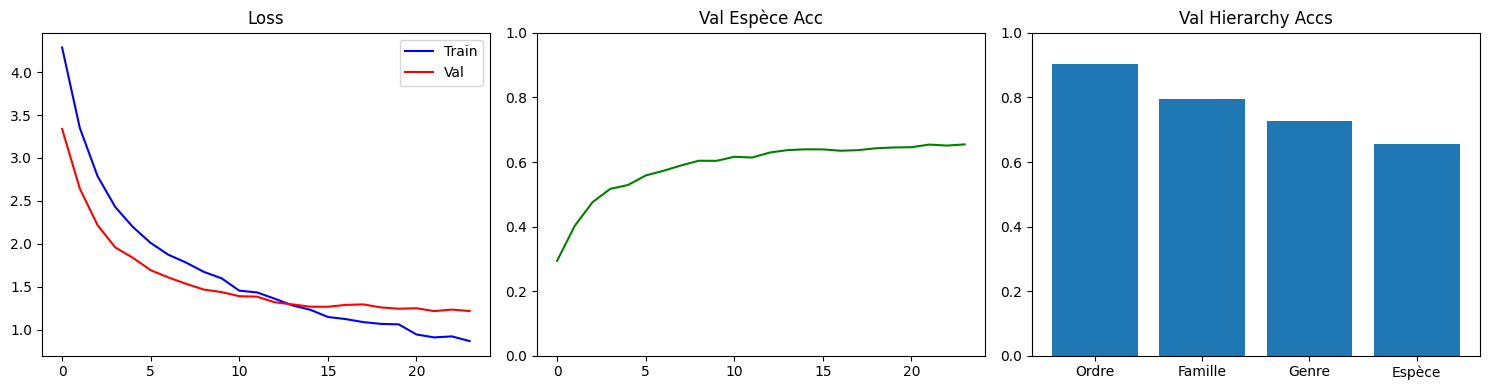

🔥 BEST: Esp.Acc=0.6545


Epoch 15: 100%|██████████| 3946/3946 [13:37<00:00,  4.82it/s, loss=1.5717]


Epoch 15: Train=0.8470 | Val=1.2408
  Accs - Ordre:0.9032 | Fam:0.7957 | Genre:0.7222 | Esp:0.6499


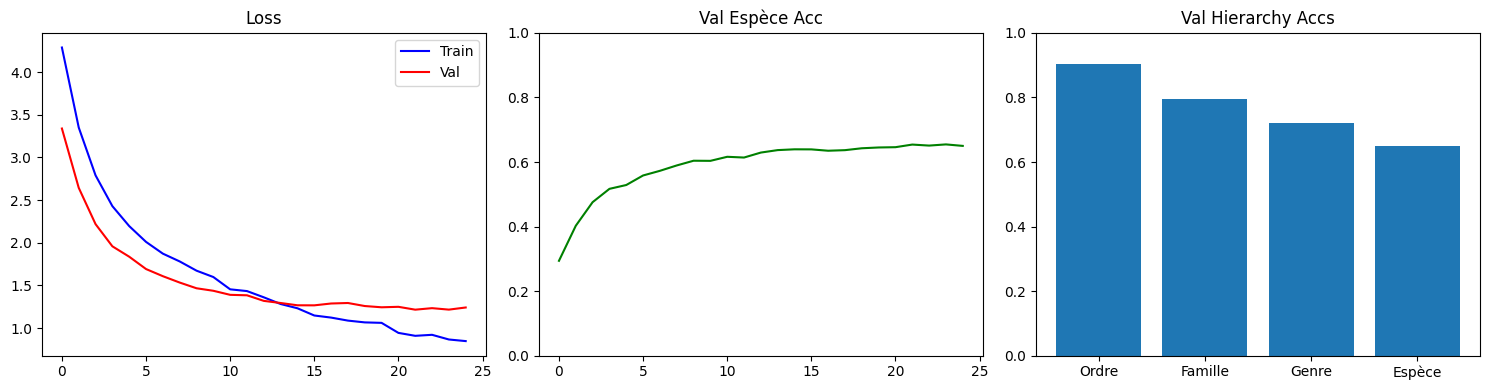

Epoch 16: 100%|██████████| 3946/3946 [13:45<00:00,  4.78it/s, loss=1.2686]


Epoch 16: Train=0.8106 | Val=1.2384
  Accs - Ordre:0.9036 | Fam:0.7942 | Genre:0.7257 | Esp:0.6556


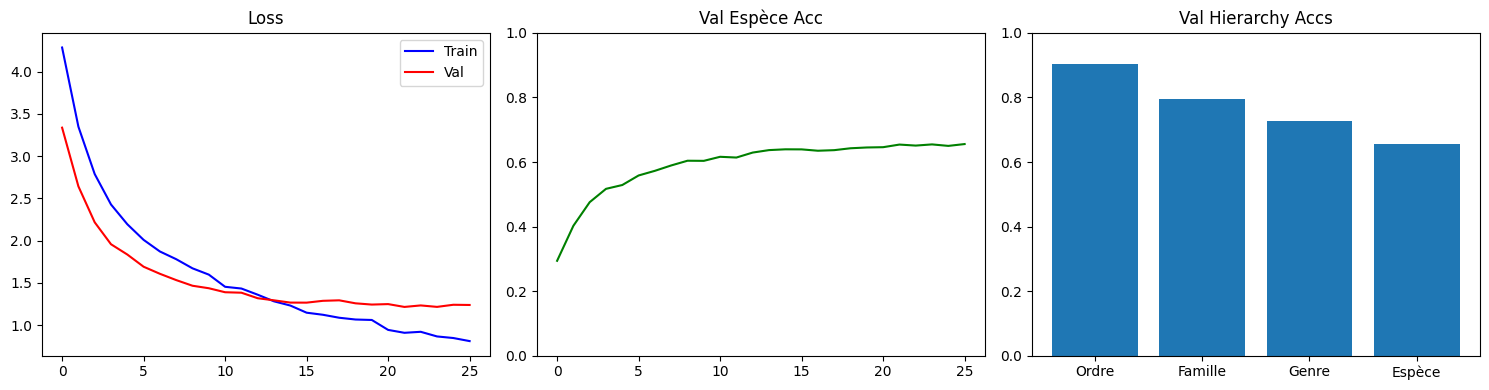

🔥 BEST: Esp.Acc=0.6556


Epoch 17: 100%|██████████| 3946/3946 [13:47<00:00,  4.77it/s, loss=1.8851]


Epoch 17: Train=0.7227 | Val=1.1992
  Accs - Ordre:0.9072 | Fam:0.8036 | Genre:0.7328 | Esp:0.6631


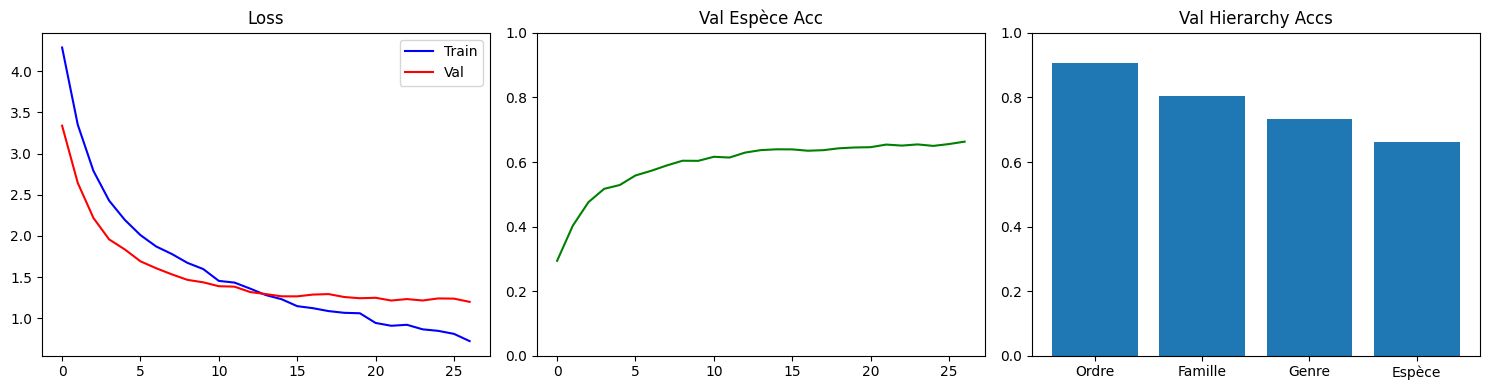

🔥 BEST: Esp.Acc=0.6631


Epoch 18: 100%|██████████| 3946/3946 [13:33<00:00,  4.85it/s, loss=2.3412]


Epoch 18: Train=0.6926 | Val=1.2020
  Accs - Ordre:0.9058 | Fam:0.8042 | Genre:0.7323 | Esp:0.6630


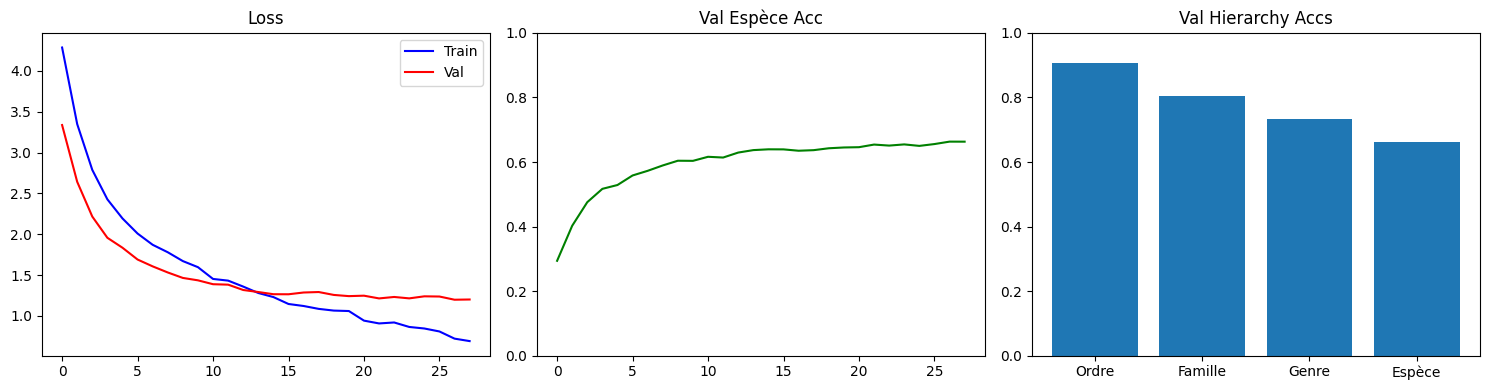

Epoch 19: 100%|██████████| 3946/3946 [13:30<00:00,  4.87it/s, loss=1.1270]


Epoch 19: Train=0.6893 | Val=1.2005
  Accs - Ordre:0.9060 | Fam:0.8055 | Genre:0.7354 | Esp:0.6651


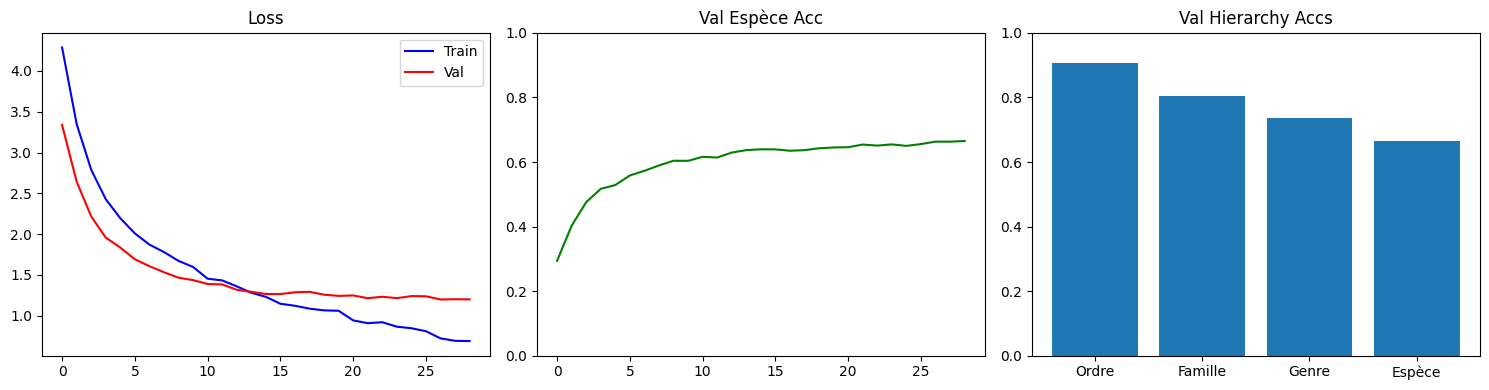

Model outputs shape: torch.Size([1, 4, 2526])
💾 ONNX exported: insect_model_epoch_20.onnx
🔥 BEST: Esp.Acc=0.6651


Epoch 20: 100%|██████████| 3946/3946 [13:59<00:00,  4.70it/s, loss=0.9426]


Epoch 20: Train=0.6287 | Val=1.2143
  Accs - Ordre:0.9054 | Fam:0.8024 | Genre:0.7351 | Esp:0.6624


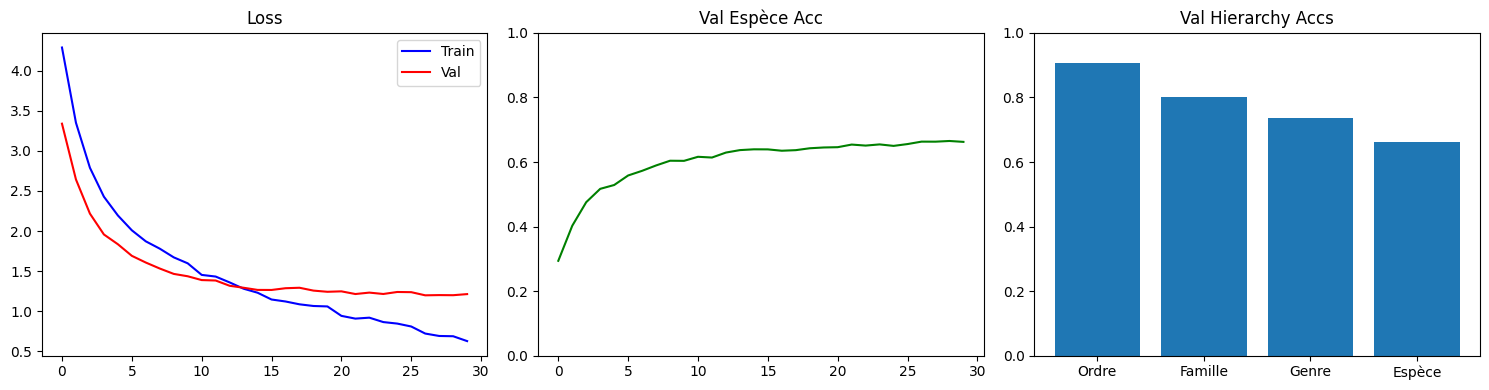

Epoch 21: 100%|██████████| 3946/3946 [13:26<00:00,  4.89it/s, loss=1.6744]


Epoch 21: Train=0.6334 | Val=1.1944
  Accs - Ordre:0.9080 | Fam:0.8073 | Genre:0.7384 | Esp:0.6675


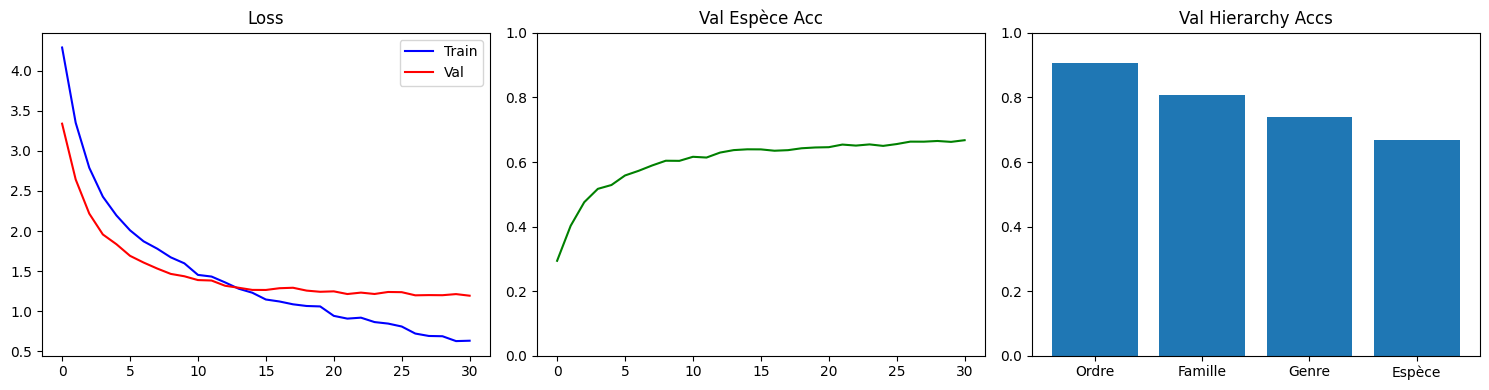

🔥 BEST: Esp.Acc=0.6675


Epoch 22: 100%|██████████| 3946/3946 [13:21<00:00,  4.92it/s, loss=1.8412]


Epoch 22: Train=0.6229 | Val=1.2065
  Accs - Ordre:0.9085 | Fam:0.8061 | Genre:0.7368 | Esp:0.6633


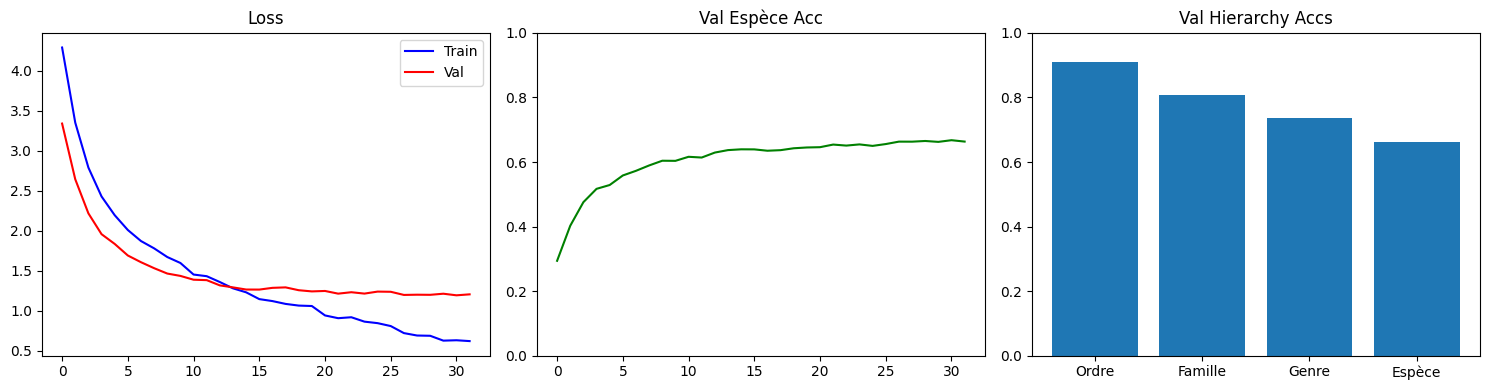

Epoch 23: 100%|██████████| 3946/3946 [13:19<00:00,  4.94it/s, loss=1.0657]


Epoch 23: Train=0.5922 | Val=1.2108
  Accs - Ordre:0.9078 | Fam:0.8044 | Genre:0.7336 | Esp:0.6627


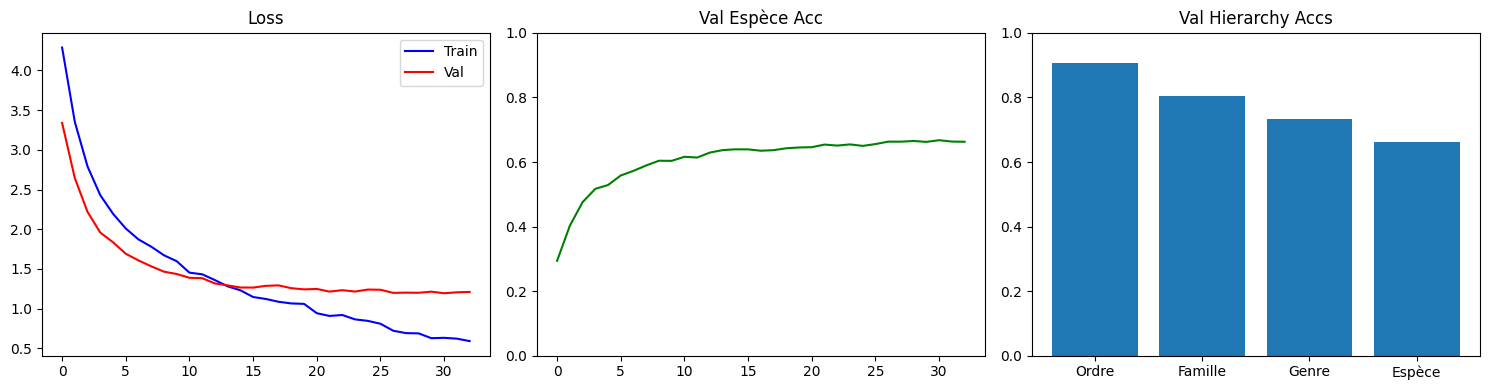

Epoch 24: 100%|██████████| 3946/3946 [13:23<00:00,  4.91it/s, loss=1.9765]


Epoch 24: Train=0.6078 | Val=1.2101
  Accs - Ordre:0.9068 | Fam:0.8081 | Genre:0.7373 | Esp:0.6642


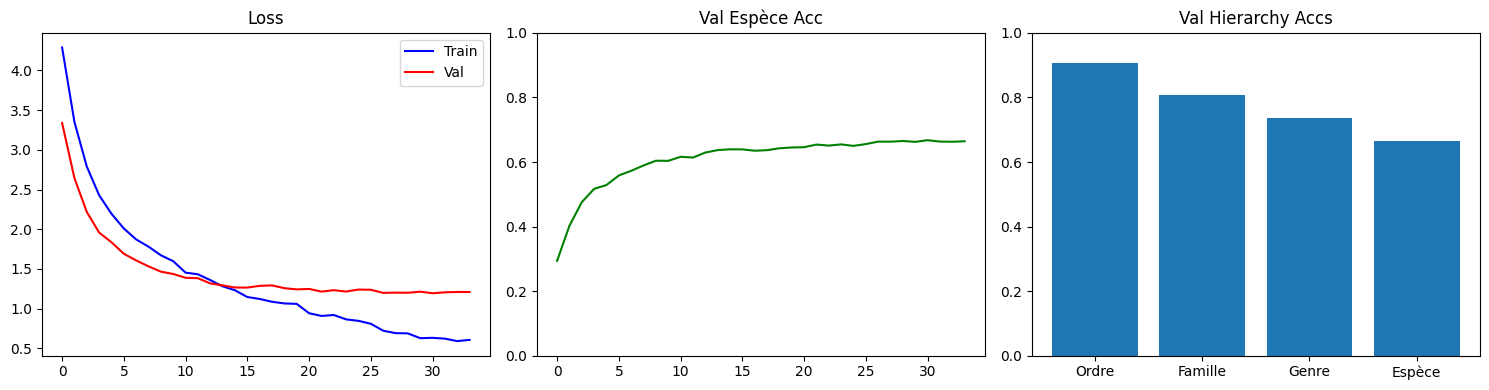

Epoch 25: 100%|██████████| 3946/3946 [13:22<00:00,  4.92it/s, loss=1.7299]


Epoch 25: Train=0.5903 | Val=1.2111
  Accs - Ordre:0.9077 | Fam:0.8071 | Genre:0.7359 | Esp:0.6665


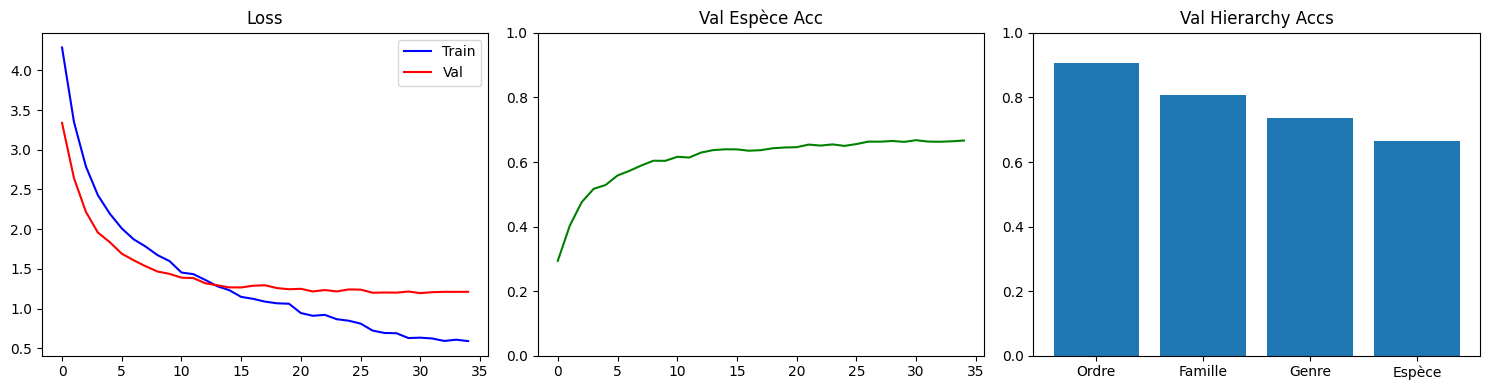

Epoch 26: 100%|██████████| 3946/3946 [13:22<00:00,  4.92it/s, loss=1.1685]


Epoch 26: Train=0.5389 | Val=1.1977
  Accs - Ordre:0.9089 | Fam:0.8112 | Genre:0.7407 | Esp:0.6709


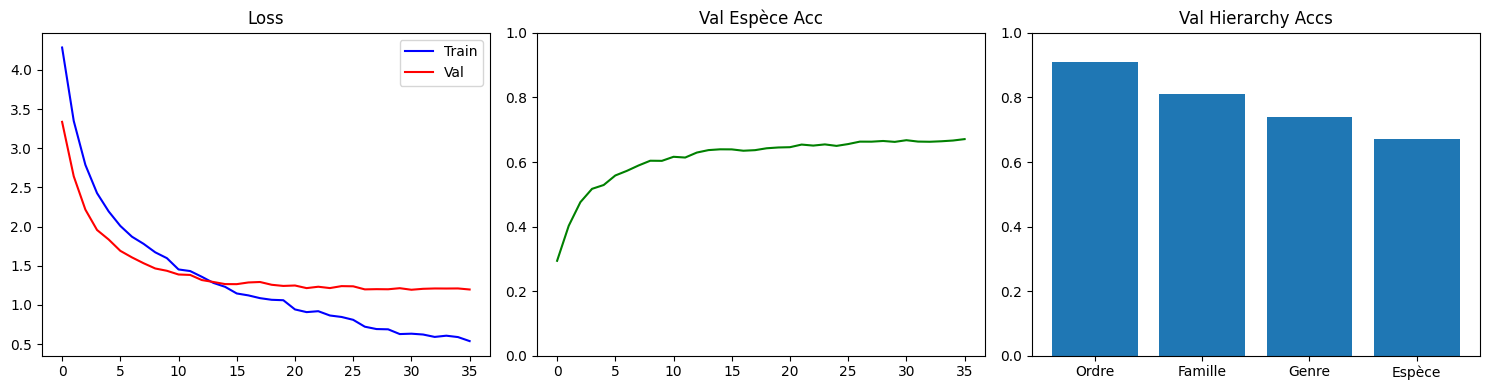

🔥 BEST: Esp.Acc=0.6709


Epoch 27: 100%|██████████| 3946/3946 [13:21<00:00,  4.92it/s, loss=2.9346]


Epoch 27: Train=0.5247 | Val=1.2029
  Accs - Ordre:0.9083 | Fam:0.8087 | Genre:0.7397 | Esp:0.6688


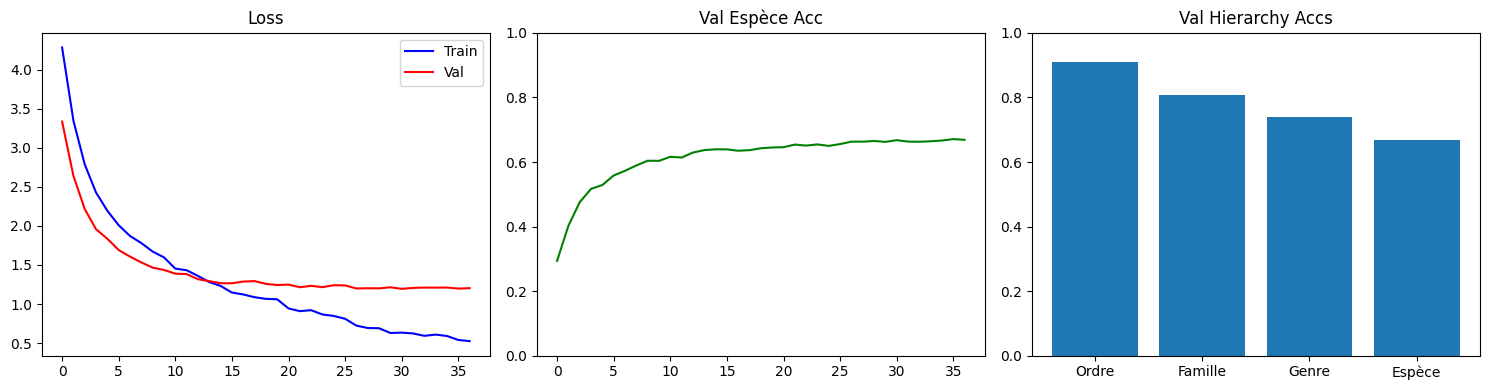

Epoch 28: 100%|██████████| 3946/3946 [13:33<00:00,  4.85it/s, loss=0.5135]


Epoch 28: Train=0.5143 | Val=1.2058
  Accs - Ordre:0.9092 | Fam:0.8114 | Genre:0.7403 | Esp:0.6685


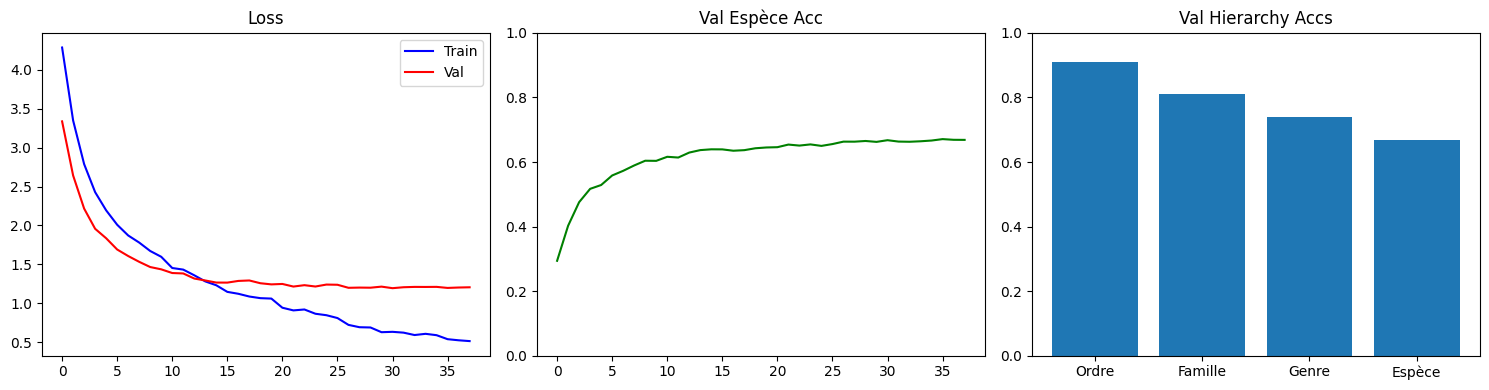

Epoch 29: 100%|██████████| 3946/3946 [13:30<00:00,  4.87it/s, loss=1.9637]


Epoch 29: Train=0.4929 | Val=1.2049
  Accs - Ordre:0.9074 | Fam:0.8119 | Genre:0.7415 | Esp:0.6692


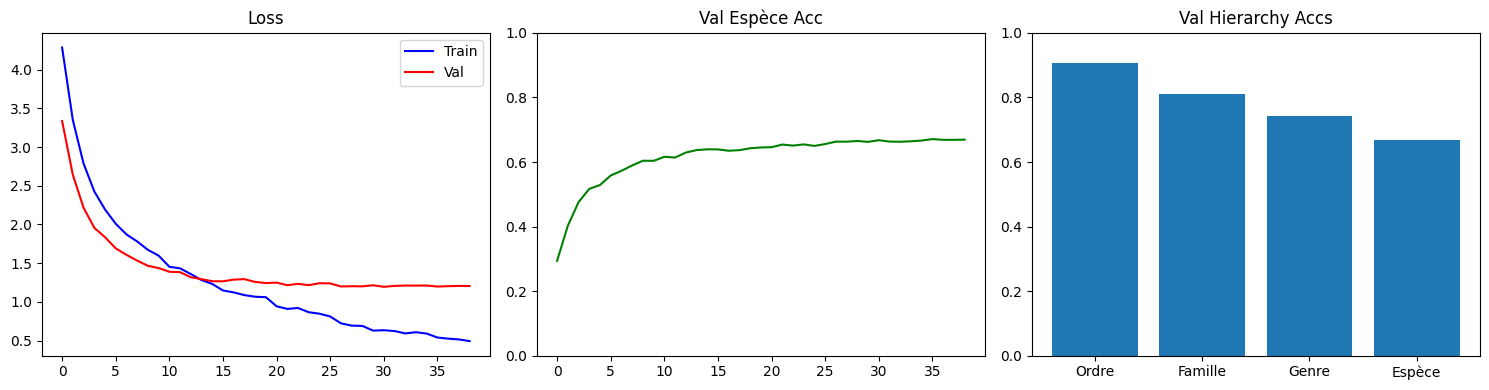

Model outputs shape: torch.Size([1, 4, 2526])
💾 ONNX exported: insect_model_epoch_30.onnx


Epoch 30: 100%|██████████| 3946/3946 [13:33<00:00,  4.85it/s, loss=1.5622]


Epoch 30: Train=0.4783 | Val=1.2007
  Accs - Ordre:0.9092 | Fam:0.8122 | Genre:0.7426 | Esp:0.6688


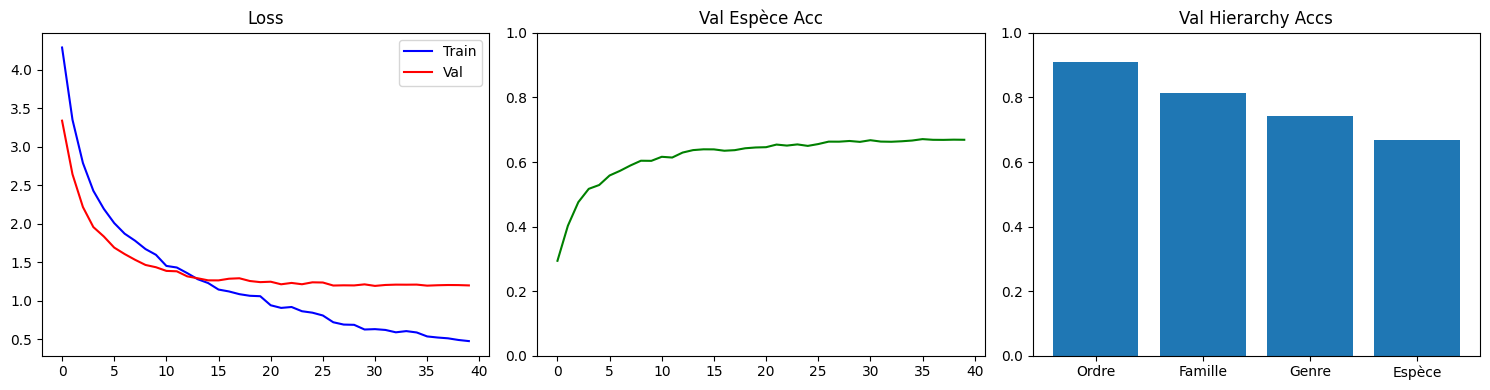

Epoch 31: 100%|██████████| 3946/3946 [13:39<00:00,  4.82it/s, loss=2.3702]


Epoch 31: Train=0.4722 | Val=1.2040
  Accs - Ordre:0.9086 | Fam:0.8118 | Genre:0.7420 | Esp:0.6709


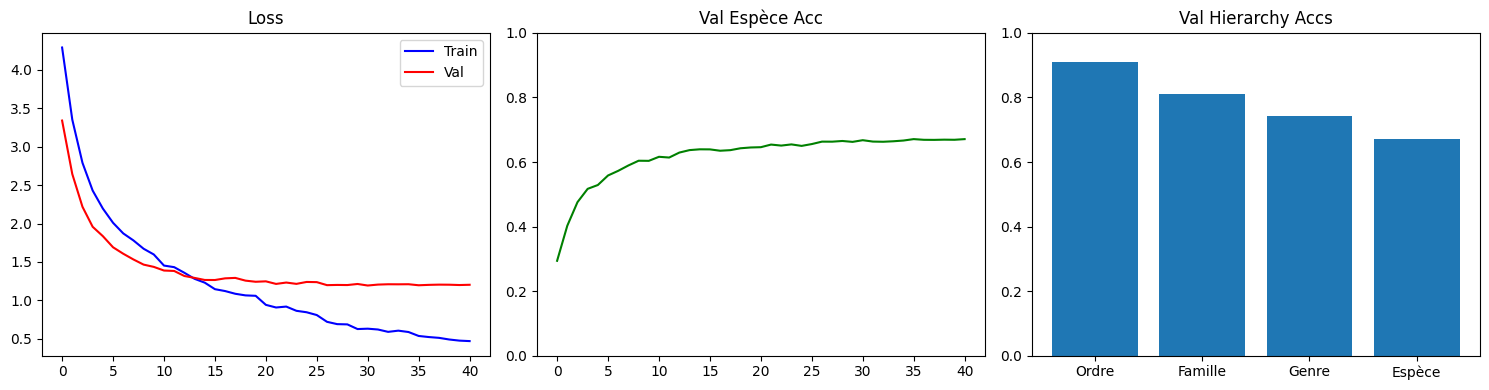

Epoch 32:  94%|█████████▍| 3710/3946 [12:50<00:51,  4.58it/s, loss=0.5109]

In [ ]:
import torch
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.onnx

checkpoint = torch.load('/kaggle/working/best_hier_model.pth', map_location=device)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optim'])

start_epoch = checkpoint['epoch'] + 1
best_val_acc = checkpoint['val_acc']
train_losses, val_losses, val_accs = checkpoint['stats']['train_losses'], checkpoint['stats']['val_losses'], checkpoint['stats']['val_accs']

# Hierarchy accs history si disponible
if 'hierarchy_accs' in checkpoint['stats']:
    hierarchy_accs.update({k: v[-1:] for k, v in checkpoint['stats']['hierarchy_accs'].items()})

print(f"✅ Repris epoch {start_epoch}, Best Acc: {best_val_acc:.4f}")
print(f"📊 History: {len(train_losses)} epochs déjà faits")

print("🚀 Début entraînement hiérarchique")

for epoch in range(50):
    # === TRAIN ===
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch:2d}')
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with autocast('cuda'):
            preds = model(images)  # [B,4,2526]
            loss = criterion(preds, labels)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_train_loss = train_loss / len(train_loader)
    
    # === VAL ===
    model.eval()
    val_loss_total = 0
    val_correct = [0,0,0,0]  # [ordre, famille, genre, espèce]
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            preds = model(images)
            loss = criterion(preds, labels)
            val_loss_total += loss.item()
        
            for lvl in range(4):
                logits = preds[:, lvl, :criterion.num_classes[lvl]]
                lvl_preds = logits.argmax(1)
                val_correct[lvl] += (lvl_preds == labels[:, lvl]).sum().item()
        
            val_total += labels.size(0)

    avg_val_loss = val_loss_total / len(val_loader)
    hierarchy_accs_current = {
        'ordre': val_correct[0]/val_total,
        'famille': val_correct[1]/val_total,
        'genre': val_correct[2]/val_total,
        'espece': val_correct[3]/val_total
    }
    val_acc = hierarchy_accs_current['espece']
    
    print(f"Epoch {epoch:2d}: Train={avg_train_loss:.4f} | Val={avg_val_loss:.4f}")
    print(f"  Accs - Ordre:{hierarchy_accs_current['ordre']:.4f} | Fam:{hierarchy_accs_current['famille']:.4f} | "
          f"Genre:{hierarchy_accs_current['genre']:.4f} | Esp:{val_acc:.4f}")
    
    # Update tracking lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    for k in hierarchy_accs:
        hierarchy_accs[k].append(hierarchy_accs_current[k])
    
    # PLOT avec vraies accuracies
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1); 
    plt.plot(train_losses, 'b-', label='Train'); plt.plot(val_losses, 'r-', label='Val'); plt.legend(); plt.title('Loss')
    plt.subplot(1,3,2); plt.plot(val_accs, 'g-'); plt.title('Val Espèce Acc'); plt.ylim(0,1)
    plt.subplot(1,3,3); 
    keys = ['Ordre','Famille','Genre','Espèce']
    accs = [hierarchy_accs_current['ordre'], hierarchy_accs_current['famille'], 
            hierarchy_accs_current['genre'], hierarchy_accs_current['espece']]
    plt.bar(keys, accs); plt.title('Val Hierarchy Accs'); plt.ylim(0,1)
    plt.tight_layout(); plt.show()
    
    # EXPORT ONNX toutes les 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        
        # Test forward pour voir les vraies outputs
        with torch.no_grad():
            test_output = model(dummy_input)
            print(f"Model outputs shape: {test_output.shape if isinstance(test_output, torch.Tensor) else [o.shape for o in test_output]}")
        
        # Export simple (1 input → 1 output principal)
        torch.onnx.export(
            model, 
            dummy_input, 
            f"insect_model_epoch_{epoch+1}.onnx",
            export_params=True, 
            opset_version=17,  # +récent = mieux support
            do_constant_folding=True,
            input_names=['image'],
            output_names=['logits'],  # 1 seul output
            dynamic_axes={
                'image': {0: 'batch_size'},
                'logits': {0: 'batch_size'}
            }
        )
        print(f"💾 ONNX exported: insect_model_epoch_{epoch+1}.onnx")

    
    # SAVE BEST
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'model': model.state_dict(),
            'optim': optimizer.state_dict(),
            'epoch': epoch,
            'val_acc': val_acc,
            'hierarchy_accs': hierarchy_accs_current,
            'stats': {'train_losses': train_losses.copy(), 'val_losses': val_losses.copy(), 
                     'val_accs': val_accs.copy(), 'hierarchy_accs': hierarchy_accs.copy()}
        }, 'best_hier_model.pth')
        print(f"🔥 BEST: Esp.Acc={val_acc:.4f}")
    else:
        patience_counter += 1
    
    scheduler.step(avg_val_loss)
    
    if patience_counter >= patience:
        print(f"🛑 Early Stop at epoch {epoch}")
        break

print(f"🏆 FINAL: Best Espèce Acc = {best_val_acc:.4f}")